# Importando bibliotecas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
import numpy as np
import random
import holidays
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from prophet import Prophet
from sklearn.model_selection import ParameterGrid

C:\Users\alex\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Definindo funções

In [2]:
def df_tratamento_dados(df):
    df['data'] = pd.to_datetime(df['data'], format='%Y-%m-%d')
    df = df.sort_values(by='data')
    # Completando dados
    # Crie um novo DataFrame com um intervalo completo de datas
    data_inicio = df['data'].min()  # Data de início
    data_fim = df['data'].max()  
    datas_completas = pd.date_range(start=data_inicio, end=data_fim, freq='D')
    # Crie um novo DataFrame com o intervalo completo de datas
    df_completo = pd.DataFrame(datas_completas, columns=['data'])# Faça um merge com o dataframe original

    df = df_completo.merge(df, on='data', how='left')
    df = df.sort_values(by='data')

    
    df['valor'] = pd.to_numeric(df['valor'], errors='coerce')
    df.index = pd.to_datetime(df['data'])
    # Interpolação linear
    df['valor'] = df['valor'].interpolate(method='linear')
    df['valor'] = df['valor'].fillna(method='bfill')
    df.sort_index(ascending=True, inplace=True)
    df = df.asfreq('D')
    # Renomeia as colunas
    df = df.rename(columns={'data': 'ds', 'valor': 'y'})
    return df

## Leitura dos dados tratados

In [3]:
def ler_csv(caminho_arquivo):
    return pd.read_csv(caminho_arquivo, sep=',',usecols=[0,1], decimal=',', header=0)

treino = ler_csv('dados_tratados/treino.csv')
teste = ler_csv('dados_tratados/teste.csv')
previsao = ler_csv('dados_tratados/previsao.csv')

In [4]:
treino = df_tratamento_dados(treino)
teste = df_tratamento_dados(teste)
previsao = df_tratamento_dados(previsao)

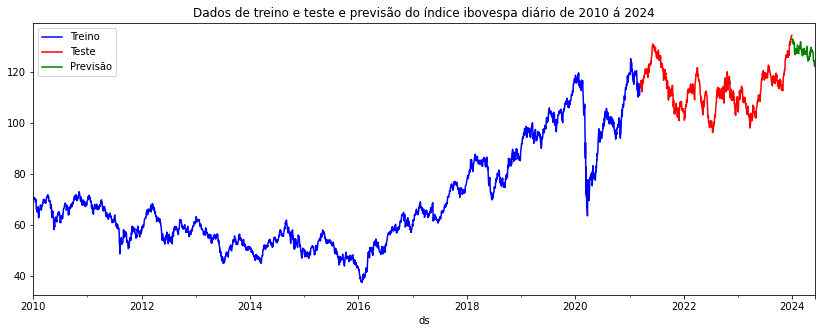

In [5]:
pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
treino.plot(kind='line', x='ds', y='y', color='blue', label='Treino', ax=ax)
teste.plot(kind='line', x='ds', y='y', color='red', label='Teste', ax=ax)
previsao.plot(kind='line', x='ds', y='y', color='green', label='Previsão', ax=ax)
plt.title('Dados de treino e teste e previsão do índice ibovespa diário de 2010 á 2024')
plt.show()

# Usando série original

## Ajuste de hiperparâmetros

In [6]:
params_grid = {'seasonality_mode':(['additive','multiplicative']),
               'changepoint_prior_scale':[0.01,0.04, 0.08],
              'holidays_prior_scale': [1,10,20],
               'changepoint_range':[0.4,0.6,0.8],
              'n_changepoints' : [50,75,90,100]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 216


In [7]:


# Cria um DataFrame vazio para armazenar os feriados
holiday = pd.DataFrame([])

# Itera sobre os feriados do Brasil entre 2010 e 2023
for date, name in sorted(holidays.Brazil(years=range(2010, 2024)).items()):
    # Adiciona os feriados ao DataFrame
    holiday = pd.concat([holiday, pd.DataFrame({'ds': date, 'holiday': name}, index=[0])], ignore_index=True)

# Converte a coluna 'ds' para o formato datetime
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

# Exibe os primeiros registros do DataFrame
print(holiday.head())

          ds                     holiday
0 2010-01-01  Confraternização Universal
1 2010-04-02           Sexta-feira Santa
2 2010-04-21                  Tiradentes
3 2010-05-01          Dia do Trabalhador
4 2010-09-07     Independência do Brasil


## Aplicando Grid Search  para selecionar melhores parâmetros 

In [8]:
%%time
model_parameters = pd.DataFrame(columns = ['RMSE','Parameters'])
best_rmse = np.inf
best_prediction=None
count = 0
for p in grid:
    
    test = pd.DataFrame()
    print(p)
    random.seed(0)
    train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         holidays_prior_scale = p['holidays_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         changepoint_range=p['changepoint_range'],
                         seasonality_mode = p['seasonality_mode'],
                         weekly_seasonality=True,
                         daily_seasonality = True,
                         yearly_seasonality = True,
                         holidays=holiday, 
                         interval_width=0.95)
    train_model.add_country_holidays(country_name='BR')
    train_model.fit(treino)
    train_forecast = train_model.make_future_dataframe(periods=len(teste), freq='D',include_history = False)
    train_forecast = train_model.predict(train_forecast)
    predicao=train_forecast[['ds','yhat']]
    Actual = teste
    RMSE = np.sqrt(mean_squared_error(Actual['y'], predicao['yhat']))
    MAE = mean_absolute_error(Actual['y'], predicao['yhat'])
    MAPE = mean_absolute_percentage_error(Actual['y'], predicao['yhat'])
    if RMSE < best_rmse:
        best_rmse = RMSE
        best_mae = MAE
        best_mape = MAPE
        best_prediction = train_forecast
    print('Root Mean Square Error(RMSE)------------------------------------',RMSE)
    model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
    count += 1
    print("total: " ,round(count/cnt,2)*100)

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


11:10:13 - cmdstanpy - INFO - Chain [1] start processing
11:10:14 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.322134044361734


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


total:  0.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


11:10:16 - cmdstanpy - INFO - Chain [1] start processing
11:10:18 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.737277316091557
total:  1.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:10:19 - cmdstanpy - INFO - Chain [1] start processing
11:10:21 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.376520011488845
total:  1.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:10:22 - cmdstanpy - INFO - Chain [1] start processing
11:10:27 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.763364314036943
total:  2.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:10:28 - cmdstanpy - INFO - Chain [1] start processing
11:10:30 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.358841832283465
total:  2.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:10:31 - cmdstanpy - INFO - Chain [1] start processing
11:10:34 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.626210411251964
total:  3.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:10:35 - cmdstanpy - INFO - Chain [1] start processing
11:10:39 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.379238897827253
total:  3.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:10:40 - cmdstanpy - INFO - Chain [1] start processing
11:10:45 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.636314500407778
total:  4.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:10:46 - cmdstanpy - INFO - Chain [1] start processing
11:10:47 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.274463939314755
total:  4.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:10:48 - cmdstanpy - INFO - Chain [1] start processing
11:10:49 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.75286679790066
total:  5.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:10:51 - cmdstanpy - INFO - Chain [1] start processing
11:10:52 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.463905080584356
total:  5.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:10:53 - cmdstanpy - INFO - Chain [1] start processing
11:10:55 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.594780955412343
total:  6.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:10:56 - cmdstanpy - INFO - Chain [1] start processing
11:10:58 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.345330465681709
total:  6.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:10:59 - cmdstanpy - INFO - Chain [1] start processing
11:11:04 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.811841234600537
total:  6.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:11:05 - cmdstanpy - INFO - Chain [1] start processing
11:11:07 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.361281857122332
total:  7.000000000000001
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:11:08 - cmdstanpy - INFO - Chain [1] start processing
11:11:12 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.645884238990936
total:  7.000000000000001
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:11:13 - cmdstanpy - INFO - Chain [1] start processing
11:11:14 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.32226061102121
total:  8.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:11:15 - cmdstanpy - INFO - Chain [1] start processing
11:11:17 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.743765292305941
total:  8.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:11:18 - cmdstanpy - INFO - Chain [1] start processing
11:11:19 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.348525214017718
total:  9.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:11:20 - cmdstanpy - INFO - Chain [1] start processing
11:11:25 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.753183351842994
total:  9.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:11:26 - cmdstanpy - INFO - Chain [1] start processing
11:11:27 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.354610295176062
total:  10.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:11:29 - cmdstanpy - INFO - Chain [1] start processing
11:11:33 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.748360048042496
total:  10.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:11:34 - cmdstanpy - INFO - Chain [1] start processing
11:11:35 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.378131672428152
total:  11.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:11:37 - cmdstanpy - INFO - Chain [1] start processing
11:11:40 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.6508949495877
total:  11.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:11:41 - cmdstanpy - INFO - Chain [1] start processing
11:11:42 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.492266523015164
total:  12.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:11:43 - cmdstanpy - INFO - Chain [1] start processing
11:11:49 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.55204522613904
total:  12.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:11:50 - cmdstanpy - INFO - Chain [1] start processing
11:11:52 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.517089671613103
total:  12.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:11:53 - cmdstanpy - INFO - Chain [1] start processing
11:12:03 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.62547586845019
total:  13.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:12:04 - cmdstanpy - INFO - Chain [1] start processing
11:12:06 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.54319460044658
total:  13.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:12:07 - cmdstanpy - INFO - Chain [1] start processing
11:12:19 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.5731079337155
total:  14.000000000000002
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:12:20 - cmdstanpy - INFO - Chain [1] start processing
11:12:22 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.531448556555773
total:  14.000000000000002
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:12:23 - cmdstanpy - INFO - Chain [1] start processing
11:12:34 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.640935488934215
total:  15.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:12:37 - cmdstanpy - INFO - Chain [1] start processing
11:12:41 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.467453553039032
total:  15.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:12:43 - cmdstanpy - INFO - Chain [1] start processing
11:12:50 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.541111122023775
total:  16.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:12:51 - cmdstanpy - INFO - Chain [1] start processing
11:12:53 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.60193687697444
total:  16.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:12:54 - cmdstanpy - INFO - Chain [1] start processing
11:13:00 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.664203610368386
total:  17.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:13:01 - cmdstanpy - INFO - Chain [1] start processing
11:13:03 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.55496753144391
total:  17.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:13:04 - cmdstanpy - INFO - Chain [1] start processing
11:13:22 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.648364673545007
total:  18.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:13:23 - cmdstanpy - INFO - Chain [1] start processing
11:13:25 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.49142012161236
total:  18.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:13:26 - cmdstanpy - INFO - Chain [1] start processing
11:13:39 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.577731558809546
total:  19.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:13:40 - cmdstanpy - INFO - Chain [1] start processing
11:13:41 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.445521870000466
total:  19.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:13:42 - cmdstanpy - INFO - Chain [1] start processing
11:13:48 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.638133426016434
total:  19.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:13:49 - cmdstanpy - INFO - Chain [1] start processing
11:13:52 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.492275582959813
total:  20.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:13:55 - cmdstanpy - INFO - Chain [1] start processing
11:14:05 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.642841269851452
total:  20.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:14:06 - cmdstanpy - INFO - Chain [1] start processing
11:14:08 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.525297341847928
total:  21.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:14:09 - cmdstanpy - INFO - Chain [1] start processing
11:14:28 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.582027434544074
total:  21.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:14:29 - cmdstanpy - INFO - Chain [1] start processing
11:14:32 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.5718795477554
total:  22.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:14:33 - cmdstanpy - INFO - Chain [1] start processing
11:14:44 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.656930109792324
total:  22.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:14:45 - cmdstanpy - INFO - Chain [1] start processing
11:14:47 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.904327900263192
total:  23.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:14:48 - cmdstanpy - INFO - Chain [1] start processing
11:14:52 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.355143587089552
total:  23.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:14:53 - cmdstanpy - INFO - Chain [1] start processing
11:14:55 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.826908678397647
total:  24.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:14:56 - cmdstanpy - INFO - Chain [1] start processing
11:15:20 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.385658242356818
total:  24.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:15:21 - cmdstanpy - INFO - Chain [1] start processing
11:15:23 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.725960762562075
total:  25.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:15:24 - cmdstanpy - INFO - Chain [1] start processing
11:15:45 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.419993085891514
total:  25.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:15:46 - cmdstanpy - INFO - Chain [1] start processing
11:15:48 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.953599152649433
total:  25.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:15:49 - cmdstanpy - INFO - Chain [1] start processing
11:16:16 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.440900306054408
total:  26.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:16:17 - cmdstanpy - INFO - Chain [1] start processing
11:16:18 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.866718773648184
total:  26.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:16:19 - cmdstanpy - INFO - Chain [1] start processing
11:16:32 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.445957402359916
total:  27.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:16:33 - cmdstanpy - INFO - Chain [1] start processing
11:16:35 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.832806024043196
total:  27.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:16:36 - cmdstanpy - INFO - Chain [1] start processing
11:16:57 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.434180545490634
total:  28.000000000000004
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:16:58 - cmdstanpy - INFO - Chain [1] start processing
11:16:59 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.00947366533596
total:  28.000000000000004
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:17:01 - cmdstanpy - INFO - Chain [1] start processing
11:17:30 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.382637037820437
total:  28.999999999999996
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:17:32 - cmdstanpy - INFO - Chain [1] start processing
11:17:34 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.84079906116583
total:  28.999999999999996
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:17:35 - cmdstanpy - INFO - Chain [1] start processing
11:17:57 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.434591964112903
total:  30.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:17:58 - cmdstanpy - INFO - Chain [1] start processing
11:18:00 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.897885290125451
total:  30.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:18:03 - cmdstanpy - INFO - Chain [1] start processing
11:18:21 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.435149093230434
total:  31.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:18:23 - cmdstanpy - INFO - Chain [1] start processing
11:18:24 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.905558696417895
total:  31.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:18:26 - cmdstanpy - INFO - Chain [1] start processing
11:18:43 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.462627719883143
total:  31.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:18:45 - cmdstanpy - INFO - Chain [1] start processing
11:18:47 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.719454335868553
total:  32.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:18:48 - cmdstanpy - INFO - Chain [1] start processing
11:19:11 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.419130840436996
total:  32.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:19:12 - cmdstanpy - INFO - Chain [1] start processing
11:19:14 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.008588237254394
total:  33.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:19:15 - cmdstanpy - INFO - Chain [1] start processing
11:20:01 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.56699130399742
total:  33.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:20:02 - cmdstanpy - INFO - Chain [1] start processing
11:20:05 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.282245996400059
total:  34.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:20:06 - cmdstanpy - INFO - Chain [1] start processing
11:20:18 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.49939196582238
total:  34.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:20:19 - cmdstanpy - INFO - Chain [1] start processing
11:20:22 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.211385440222731
total:  35.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:20:23 - cmdstanpy - INFO - Chain [1] start processing
11:20:38 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.43762083450127
total:  35.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:20:40 - cmdstanpy - INFO - Chain [1] start processing
11:20:43 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.20952735622003
total:  36.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:20:44 - cmdstanpy - INFO - Chain [1] start processing
11:20:58 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.398820284471945
total:  36.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:20:59 - cmdstanpy - INFO - Chain [1] start processing
11:21:02 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.197408617940825
total:  37.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:21:04 - cmdstanpy - INFO - Chain [1] start processing
11:21:19 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.304720702030796
total:  37.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:21:20 - cmdstanpy - INFO - Chain [1] start processing
11:21:23 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.26118247926276
total:  38.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:21:24 - cmdstanpy - INFO - Chain [1] start processing
11:21:32 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.550828032003945
total:  38.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:21:33 - cmdstanpy - INFO - Chain [1] start processing
11:21:37 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.218991148306252
total:  38.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:21:38 - cmdstanpy - INFO - Chain [1] start processing
11:21:46 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.384394287847876
total:  39.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:21:47 - cmdstanpy - INFO - Chain [1] start processing
11:21:51 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.213811553657472
total:  39.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:21:52 - cmdstanpy - INFO - Chain [1] start processing
11:22:10 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.400882869397684
total:  40.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:22:11 - cmdstanpy - INFO - Chain [1] start processing
11:22:14 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.217396883180436
total:  40.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:22:16 - cmdstanpy - INFO - Chain [1] start processing
11:22:36 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.38584153762934
total:  41.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:22:38 - cmdstanpy - INFO - Chain [1] start processing
11:22:39 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.232853768552973
total:  41.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:22:40 - cmdstanpy - INFO - Chain [1] start processing
11:22:51 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.494184051445703
total:  42.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:22:52 - cmdstanpy - INFO - Chain [1] start processing
11:22:56 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.23057627986945
total:  42.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:22:57 - cmdstanpy - INFO - Chain [1] start processing
11:23:04 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.421064155839318
total:  43.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:23:05 - cmdstanpy - INFO - Chain [1] start processing
11:23:12 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.279607070081408
total:  43.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:23:14 - cmdstanpy - INFO - Chain [1] start processing
11:23:28 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.39592712552534
total:  44.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:23:34 - cmdstanpy - INFO - Chain [1] start processing
11:23:44 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.209079135456014
total:  44.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:23:45 - cmdstanpy - INFO - Chain [1] start processing
11:24:00 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.414318537873093
total:  44.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:24:04 - cmdstanpy - INFO - Chain [1] start processing
11:24:09 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.03739965765211
total:  45.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:24:10 - cmdstanpy - INFO - Chain [1] start processing
11:24:23 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.605801976690877
total:  45.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:24:24 - cmdstanpy - INFO - Chain [1] start processing
11:24:29 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.121558416079782
total:  46.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:24:31 - cmdstanpy - INFO - Chain [1] start processing
11:24:55 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.611943149811562
total:  46.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:24:56 - cmdstanpy - INFO - Chain [1] start processing
11:25:01 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.11224873961056
total:  47.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:25:02 - cmdstanpy - INFO - Chain [1] start processing
11:25:25 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.63596759856587
total:  47.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:25:26 - cmdstanpy - INFO - Chain [1] start processing
11:25:30 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.12902419346309
total:  48.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:25:31 - cmdstanpy - INFO - Chain [1] start processing
11:26:05 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.65344297864428
total:  48.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:26:06 - cmdstanpy - INFO - Chain [1] start processing
11:26:08 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.079616624399517
total:  49.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:26:09 - cmdstanpy - INFO - Chain [1] start processing
11:26:23 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.645223949487853
total:  49.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:26:24 - cmdstanpy - INFO - Chain [1] start processing
11:26:27 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.126663617998425
total:  50.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:26:29 - cmdstanpy - INFO - Chain [1] start processing
11:26:45 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.60475852488601
total:  50.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:26:48 - cmdstanpy - INFO - Chain [1] start processing
11:26:58 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.114344930383638
total:  50.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:26:59 - cmdstanpy - INFO - Chain [1] start processing
11:27:35 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.619873850311894
total:  51.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:27:36 - cmdstanpy - INFO - Chain [1] start processing
11:27:47 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.1056766202715
total:  51.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:27:50 - cmdstanpy - INFO - Chain [1] start processing
11:28:48 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.609828058022895
total:  52.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:28:49 - cmdstanpy - INFO - Chain [1] start processing
11:28:52 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.088908632404248
total:  52.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:28:53 - cmdstanpy - INFO - Chain [1] start processing
11:29:03 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.619917878930913
total:  53.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:29:05 - cmdstanpy - INFO - Chain [1] start processing
11:29:09 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.119760924873958
total:  53.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:29:11 - cmdstanpy - INFO - Chain [1] start processing
11:29:52 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.62760263172475
total:  54.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:29:53 - cmdstanpy - INFO - Chain [1] start processing
11:29:57 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.113559890123106
total:  54.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:29:58 - cmdstanpy - INFO - Chain [1] start processing
11:30:26 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.623698970363506
total:  55.00000000000001
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:30:32 - cmdstanpy - INFO - Chain [1] start processing
11:30:40 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.090991881631098
total:  55.00000000000001
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:30:41 - cmdstanpy - INFO - Chain [1] start processing
11:30:58 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.690258102795216
total:  56.00000000000001
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:30:59 - cmdstanpy - INFO - Chain [1] start processing
11:31:01 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.915079005713222
total:  56.00000000000001
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:31:03 - cmdstanpy - INFO - Chain [1] start processing
11:31:24 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.820758206743044
total:  56.00000000000001
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:31:27 - cmdstanpy - INFO - Chain [1] start processing
11:31:33 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.886550639896969
total:  56.99999999999999
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:31:34 - cmdstanpy - INFO - Chain [1] start processing
11:31:51 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.835762773968018
total:  56.99999999999999
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:31:53 - cmdstanpy - INFO - Chain [1] start processing
11:32:01 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.966939617953587
total:  57.99999999999999
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:32:06 - cmdstanpy - INFO - Chain [1] start processing
11:32:32 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.804039219459376
total:  57.99999999999999
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:32:33 - cmdstanpy - INFO - Chain [1] start processing
11:32:38 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.961512707220939
total:  59.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:32:39 - cmdstanpy - INFO - Chain [1] start processing
11:33:03 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.817062947761709
total:  59.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:33:06 - cmdstanpy - INFO - Chain [1] start processing
11:33:12 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.913898875348064
total:  60.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:33:15 - cmdstanpy - INFO - Chain [1] start processing
11:33:30 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.81089544968779
total:  60.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:33:31 - cmdstanpy - INFO - Chain [1] start processing
11:33:36 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.848150073367949
total:  61.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:33:37 - cmdstanpy - INFO - Chain [1] start processing
11:34:01 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.915759437416938
total:  61.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:34:02 - cmdstanpy - INFO - Chain [1] start processing
11:34:06 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.963184947774849
total:  62.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:34:07 - cmdstanpy - INFO - Chain [1] start processing
11:34:27 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.90350652383208
total:  62.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:34:28 - cmdstanpy - INFO - Chain [1] start processing
11:34:32 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.973867662362347
total:  62.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:34:33 - cmdstanpy - INFO - Chain [1] start processing
11:35:02 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.885461196072862
total:  63.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:35:04 - cmdstanpy - INFO - Chain [1] start processing
11:35:06 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.937495790521599
total:  63.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:35:07 - cmdstanpy - INFO - Chain [1] start processing
11:35:24 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.863456803400963
total:  64.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:35:28 - cmdstanpy - INFO - Chain [1] start processing
11:35:40 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.812741857185609
total:  64.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:35:41 - cmdstanpy - INFO - Chain [1] start processing
11:36:07 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.033805585736829
total:  65.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:36:13 - cmdstanpy - INFO - Chain [1] start processing
11:36:20 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.949651861099664
total:  65.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:36:21 - cmdstanpy - INFO - Chain [1] start processing
11:36:42 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.80140608923363
total:  66.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:36:44 - cmdstanpy - INFO - Chain [1] start processing
11:36:47 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.005952432611245
total:  66.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:36:49 - cmdstanpy - INFO - Chain [1] start processing
11:37:18 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.837346907926236
total:  67.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:37:19 - cmdstanpy - INFO - Chain [1] start processing
11:37:22 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.562006420334956
total:  67.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:37:23 - cmdstanpy - INFO - Chain [1] start processing
11:37:28 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.81410375440021
total:  68.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:37:30 - cmdstanpy - INFO - Chain [1] start processing
11:37:35 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.505599732454993
total:  68.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:37:36 - cmdstanpy - INFO - Chain [1] start processing
11:37:51 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.7137268062213
total:  69.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:37:54 - cmdstanpy - INFO - Chain [1] start processing
11:38:00 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.49438345623321
total:  69.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:38:01 - cmdstanpy - INFO - Chain [1] start processing
11:38:13 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.680287861073467
total:  69.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:38:14 - cmdstanpy - INFO - Chain [1] start processing
11:38:20 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.48555474372533
total:  70.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:38:21 - cmdstanpy - INFO - Chain [1] start processing
11:38:32 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.511494286041692
total:  70.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:38:36 - cmdstanpy - INFO - Chain [1] start processing
11:38:51 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.518306320397842
total:  71.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:38:53 - cmdstanpy - INFO - Chain [1] start processing
11:38:59 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.624495959699193
total:  71.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:39:01 - cmdstanpy - INFO - Chain [1] start processing
11:39:08 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.488423281446973
total:  72.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:39:09 - cmdstanpy - INFO - Chain [1] start processing
11:39:13 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.490362604404467
total:  72.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:39:15 - cmdstanpy - INFO - Chain [1] start processing
11:39:26 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.49529517978367
total:  73.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:39:31 - cmdstanpy - INFO - Chain [1] start processing
11:39:41 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.55383825597637
total:  73.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:39:42 - cmdstanpy - INFO - Chain [1] start processing
11:39:50 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.50011265754968
total:  74.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:39:51 - cmdstanpy - INFO - Chain [1] start processing
11:39:56 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.51799747775731
total:  74.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:39:57 - cmdstanpy - INFO - Chain [1] start processing
11:40:01 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.533971373305855
total:  75.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:40:02 - cmdstanpy - INFO - Chain [1] start processing
11:40:08 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.879765625920605
total:  75.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:40:09 - cmdstanpy - INFO - Chain [1] start processing
11:40:16 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.511165454346532
total:  75.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:40:17 - cmdstanpy - INFO - Chain [1] start processing
11:40:31 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.69536540706639
total:  76.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:40:34 - cmdstanpy - INFO - Chain [1] start processing
11:40:39 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.496534479590935
total:  76.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:40:40 - cmdstanpy - INFO - Chain [1] start processing
11:40:53 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.776723228033287
total:  77.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:40:55 - cmdstanpy - INFO - Chain [1] start processing
11:41:01 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.50047160412297
total:  77.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:41:02 - cmdstanpy - INFO - Chain [1] start processing
11:41:24 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.758847720415535
total:  78.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:41:27 - cmdstanpy - INFO - Chain [1] start processing
11:41:33 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.53340614971355
total:  78.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:41:34 - cmdstanpy - INFO - Chain [1] start processing
11:41:49 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.51637214226819
total:  79.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:41:50 - cmdstanpy - INFO - Chain [1] start processing
11:41:56 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.57817233904363
total:  79.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:41:58 - cmdstanpy - INFO - Chain [1] start processing
11:42:25 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.601178641672163
total:  80.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:42:26 - cmdstanpy - INFO - Chain [1] start processing
11:42:34 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.563906000832258
total:  80.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:42:35 - cmdstanpy - INFO - Chain [1] start processing
11:43:01 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.609453449585782
total:  81.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:43:02 - cmdstanpy - INFO - Chain [1] start processing
11:43:14 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.541537890593414
total:  81.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:43:15 - cmdstanpy - INFO - Chain [1] start processing
11:43:32 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.617800529827722
total:  81.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:43:33 - cmdstanpy - INFO - Chain [1] start processing
11:43:38 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.54969136480209
total:  82.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:43:39 - cmdstanpy - INFO - Chain [1] start processing
11:43:59 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.578401494325583
total:  82.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:44:00 - cmdstanpy - INFO - Chain [1] start processing
11:44:06 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.56170092827369
total:  83.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:44:07 - cmdstanpy - INFO - Chain [1] start processing
11:44:28 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.604595821850346
total:  83.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:44:31 - cmdstanpy - INFO - Chain [1] start processing
11:44:41 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.56854551676982
total:  84.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:44:42 - cmdstanpy - INFO - Chain [1] start processing
11:44:51 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.590232805564327
total:  84.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:44:52 - cmdstanpy - INFO - Chain [1] start processing
11:45:03 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.557742548315204
total:  85.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:45:04 - cmdstanpy - INFO - Chain [1] start processing
11:45:18 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.607397678629255
total:  85.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:45:19 - cmdstanpy - INFO - Chain [1] start processing
11:45:31 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.547080247936528
total:  86.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:45:34 - cmdstanpy - INFO - Chain [1] start processing
11:45:49 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.579338905350667
total:  86.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:45:50 - cmdstanpy - INFO - Chain [1] start processing
11:46:03 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.57082352037233
total:  87.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:46:04 - cmdstanpy - INFO - Chain [1] start processing
11:46:20 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.564944319053005
total:  87.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:46:21 - cmdstanpy - INFO - Chain [1] start processing
11:46:29 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.53608522057974
total:  88.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:46:30 - cmdstanpy - INFO - Chain [1] start processing
11:46:55 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.59476273531231
total:  88.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:46:56 - cmdstanpy - INFO - Chain [1] start processing
11:47:02 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.589747319404317
total:  88.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:47:03 - cmdstanpy - INFO - Chain [1] start processing
11:47:25 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.489955306347934
total:  89.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:47:26 - cmdstanpy - INFO - Chain [1] start processing
11:47:31 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.362046498826613
total:  89.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:47:33 - cmdstanpy - INFO - Chain [1] start processing
11:47:54 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.977560742930262
total:  90.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:47:55 - cmdstanpy - INFO - Chain [1] start processing
11:48:04 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.507437039866382
total:  90.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:48:05 - cmdstanpy - INFO - Chain [1] start processing
11:48:28 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.163053457030976
total:  91.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:48:30 - cmdstanpy - INFO - Chain [1] start processing
11:48:38 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.511394312258007
total:  91.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:48:39 - cmdstanpy - INFO - Chain [1] start processing
11:48:59 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.038987143608953
total:  92.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:49:00 - cmdstanpy - INFO - Chain [1] start processing
11:49:18 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.539839511756782
total:  92.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:49:19 - cmdstanpy - INFO - Chain [1] start processing
11:49:40 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.028682569358596
total:  93.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:49:42 - cmdstanpy - INFO - Chain [1] start processing
11:49:54 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.561641325267114
total:  93.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:49:57 - cmdstanpy - INFO - Chain [1] start processing
11:50:16 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.073360444605504
total:  94.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:50:20 - cmdstanpy - INFO - Chain [1] start processing
11:50:31 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.484116461133798
total:  94.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:50:32 - cmdstanpy - INFO - Chain [1] start processing
11:50:55 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.242033052989719
total:  94.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:50:58 - cmdstanpy - INFO - Chain [1] start processing
11:51:10 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.532183391391074
total:  95.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:51:11 - cmdstanpy - INFO - Chain [1] start processing
11:51:31 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.122945561617192
total:  95.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:51:32 - cmdstanpy - INFO - Chain [1] start processing
11:51:41 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.454171421459092
total:  96.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:51:42 - cmdstanpy - INFO - Chain [1] start processing
11:52:04 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.125546549738234
total:  96.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:52:08 - cmdstanpy - INFO - Chain [1] start processing
11:52:17 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.465389950659372
total:  97.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:52:18 - cmdstanpy - INFO - Chain [1] start processing
11:52:33 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.986538107583208
total:  97.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:52:34 - cmdstanpy - INFO - Chain [1] start processing
11:52:46 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.626210439709823
total:  98.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:52:47 - cmdstanpy - INFO - Chain [1] start processing
11:53:05 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.129079220946279
total:  98.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:53:06 - cmdstanpy - INFO - Chain [1] start processing
11:53:14 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.506270663786248
total:  99.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:53:15 - cmdstanpy - INFO - Chain [1] start processing
11:53:35 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.226122638363238
total:  99.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:53:36 - cmdstanpy - INFO - Chain [1] start processing
11:53:53 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.546552214289353
total:  100.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
11:53:54 - cmdstanpy - INFO - Chain [1] start processing
11:54:27 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.135222204545993
total:  100.0
CPU times: total: 2min 33s
Wall time: 44min 18s


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [9]:
parameters = model_parameters.sort_values(by=['RMSE'])
parameters = parameters.reset_index(drop=True)
parameters.head()

,RMSE,Parameters,MAE,MAPE
0,11.362046,"{'changepoint_prior_scale': 0.08, 'changepoint...",9.748276,0.087453
1,11.382637,"{'changepoint_prior_scale': 0.01, 'changepoint...",9.387214,0.083506
2,11.385658,"{'changepoint_prior_scale': 0.01, 'changepoint...",9.394137,0.083574
3,11.419131,"{'changepoint_prior_scale': 0.01, 'changepoint...",9.442211,0.084044
4,11.419993,"{'changepoint_prior_scale': 0.01, 'changepoint...",9.420590,0.083773


In [10]:
print('RMSE:',parameters.loc[0, 'RMSE'])
print('MAE:',parameters.loc[0, 'MAE'])
print('MAPE:',parameters.loc[0, 'MAPE'])
print(parameters.loc[0, 'Parameters'])

RMSE: 11.362046498826613
MAE: 9.74827570373372
MAPE: 0.08745284219321625
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


## Realizando treinando modelo com dados de treino e validção e previsão para os dados de teste

In [13]:
data_inicio = previsao['ds'].iloc[0]
data_fim = previsao['ds'].iloc[-1]
future = train_model.make_future_dataframe(periods=0, freq='D', include_history=False)
future['ds'] = pd.date_range(start=data_inicio, end=data_fim)

In [12]:
previsto = train_model.predict(future)

In [15]:
treino_concat = pd.concat([treino, teste])
previsao_concat = pd.concat([previsao])

In [16]:
train_model =Prophet(changepoint_prior_scale = parameters.loc[0, 'Parameters']['changepoint_prior_scale'],
                     holidays_prior_scale = parameters.loc[0, 'Parameters']['holidays_prior_scale'],
                     n_changepoints = parameters.loc[0, 'Parameters']['n_changepoints'],
                     changepoint_range=parameters.loc[0, 'Parameters']['changepoint_range'],
                     seasonality_mode = parameters.loc[0, 'Parameters']['seasonality_mode'],
                     weekly_seasonality=True,
                     daily_seasonality = True,
                     yearly_seasonality = True,
                     holidays=holiday, 
                     interval_width=0.95)
train_model.add_country_holidays(country_name='BR')
train_model.fit(treino_concat)
train_forecast = train_model.make_future_dataframe(periods=len(previsao_concat), freq='D',include_history = False)
train_forecast = train_model.predict(train_forecast)
predicao=train_forecast[['ds','yhat']]
Actual = previsao
RMSE = np.sqrt(mean_squared_error(Actual['y'], predicao['yhat']))
MAE = mean_absolute_error(Actual['y'], predicao['yhat'])
MAPE = mean_absolute_percentage_error(Actual['y'], predicao['yhat'])

14:47:40 - cmdstanpy - INFO - Chain [1] start processing
14:48:01 - cmdstanpy - INFO - Chain [1] done processing


## Plotando dados

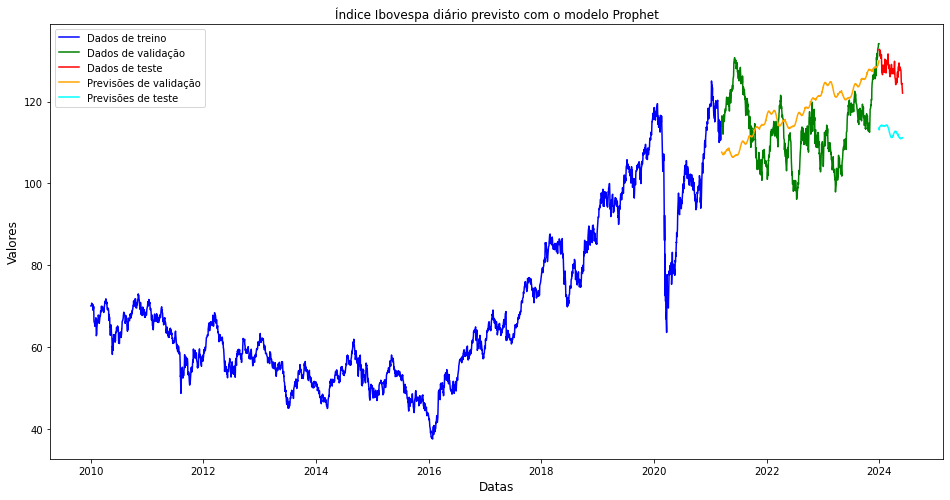

In [18]:
plt.figure(figsize=(16, 8))

plt.plot(treino['ds'], treino['y'],color='blue', label='Dados de treino')
plt.plot(teste['ds'], teste['y'],color='green', label='Dados de validação')
plt.plot(previsao['ds'], previsao['y'],color='red', label='Dados de teste')
plt.plot(teste['ds'],best_prediction['yhat'],color='orange', label='Previsões de validação')
plt.plot(previsao['ds'],predicao['yhat'],color='cyan', label='Previsões de teste')

plt.ylabel('Valores', fontsize=12)
plt.xlabel('Datas', fontsize=12)
plt.title('Índice Ibovespa diário previsto com o modelo Prophet')
# Adicionando uma legenda
plt.legend()

# Exibindo o gráfico
plt.show()

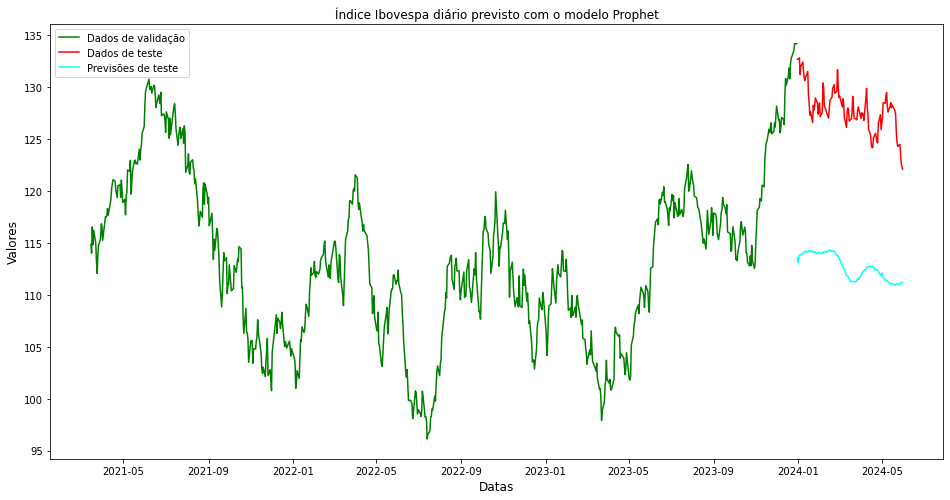

In [19]:
plt.figure(figsize=(16, 8))

#plt.plot(treino['ds'], treino['y'],color='blue', label='Dados de treino')
plt.plot(teste['ds'], teste['y'],color='green', label='Dados de validação')
plt.plot(previsao['ds'], previsao['y'],color='red', label='Dados de teste')
#plt.plot(teste['ds'],best_prediction['yhat'],color='orange', label='Previsões de validação')
plt.plot(previsao['ds'],predicao['yhat'],color='cyan', label='Previsões de teste')

plt.ylabel('Valores', fontsize=12)
plt.xlabel('Datas', fontsize=12)
plt.title('Índice Ibovespa diário previsto com o modelo Prophet')
# Adicionando uma legenda
plt.legend()

# Exibindo o gráfico
plt.show()

In [29]:
print('RMSE:',RMSE)
print('MAE:',MAE)
print('MAPE:',MAPE)
print(parameters.loc[0, 'Parameters'])

RMSE: 12.472543877948807
MAE: 12.340518539477303
MAPE: 0.09633358654905459
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


## Eliminando dados irregulares da pandemia

In [20]:
treino1  = treino.loc['2016-01-01':'2020-02-01']
treino2 = treino.loc['2020-07-02':]

In [21]:
# Defina o intervalo de datas
data_inicio = '2020-02-02'
data_fim = '2020-07-01'

# Crie as datas dentro do intervalo
datas = pd.date_range(start=data_inicio, end=data_fim, freq='D')

# Gere valores entre 110 e 120
valores = np.linspace(117.597180, 96.234960, num=len(datas))

# Crie um DataFrame com as datas e valores
dados_pand = pd.DataFrame({'ds': datas, 'y': valores})
dados_pand.index = dados_pand['ds']
#dados_pand.drop('ds', axis=1, inplace=True)

In [22]:
treino_sem_pand = pd.concat([treino1,dados_pand,treino2])

## Treinando o modelo aplicando Grid Search

In [23]:
%%time
model_parameters = pd.DataFrame(columns = ['RMSE','Parameters'])
best_rmse = np.inf
best_prediction=None
count = 0
for p in grid:
    
    test = pd.DataFrame()
    print(p)
    random.seed(0)
    train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         holidays_prior_scale = p['holidays_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         changepoint_range=p['changepoint_range'],
                         seasonality_mode = p['seasonality_mode'],
                         weekly_seasonality=True,
                         daily_seasonality = True,
                         yearly_seasonality = True,
                         holidays=holiday, 
                         interval_width=0.95)
    train_model.add_country_holidays(country_name='BR')
    train_model.fit(treino_sem_pand)
    train_forecast = train_model.make_future_dataframe(periods=len(teste), freq='D',include_history = False)
    train_forecast = train_model.predict(train_forecast)
    predicao=train_forecast[['ds','yhat']]
    Actual = teste
    RMSE = np.sqrt(mean_squared_error(Actual['y'], predicao['yhat']))
    MAE = mean_absolute_error(Actual['y'], predicao['yhat'])
    MAPE = mean_absolute_percentage_error(Actual['y'], predicao['yhat'])
    if RMSE < best_rmse:
        best_rmse = RMSE
        best_mae = MAE
        best_mape = MAPE
        best_prediction2 = train_forecast
    print('Root Mean Square Error(RMSE)------------------------------------',RMSE)
    model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
    count += 1
    print("total: " ,round(count/cnt,2)*100)

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


14:53:32 - cmdstanpy - INFO - Chain [1] start processing
14:53:32 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.753030184184574
total:  0.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:53:33 - cmdstanpy - INFO - Chain [1] start processing
14:53:34 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.031598988827795
total:  1.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:53:37 - cmdstanpy - INFO - Chain [1] start processing
14:53:39 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.845705690244888
total:  1.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:53:40 - cmdstanpy - INFO - Chain [1] start processing
14:53:41 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.108124047654442
total:  2.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:53:42 - cmdstanpy - INFO - Chain [1] start processing
14:53:43 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.798467982614273
total:  2.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:53:44 - cmdstanpy - INFO - Chain [1] start processing
14:53:45 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.126796266127258
total:  3.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:53:46 - cmdstanpy - INFO - Chain [1] start processing
14:53:46 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.7729758867494
total:  3.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:53:47 - cmdstanpy - INFO - Chain [1] start processing
14:53:48 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.193290630971763
total:  4.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:53:49 - cmdstanpy - INFO - Chain [1] start processing
14:53:49 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.78252771766579
total:  4.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:53:50 - cmdstanpy - INFO - Chain [1] start processing
14:53:51 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.1176802943781
total:  5.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:53:51 - cmdstanpy - INFO - Chain [1] start processing
14:53:52 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.54765821271147
total:  5.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:53:53 - cmdstanpy - INFO - Chain [1] start processing
14:53:53 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.989263582550006
total:  6.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:53:54 - cmdstanpy - INFO - Chain [1] start processing
14:53:54 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.90495757811872
total:  6.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:53:55 - cmdstanpy - INFO - Chain [1] start processing
14:53:59 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.91129288518861
total:  6.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:54:01 - cmdstanpy - INFO - Chain [1] start processing
14:54:02 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.864022511824263
total:  7.000000000000001
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:54:04 - cmdstanpy - INFO - Chain [1] start processing
14:54:05 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.115934700125692
total:  7.000000000000001
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:54:06 - cmdstanpy - INFO - Chain [1] start processing
14:54:06 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.818977304022145
total:  8.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:54:07 - cmdstanpy - INFO - Chain [1] start processing
14:54:08 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.989248863622866
total:  8.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:54:09 - cmdstanpy - INFO - Chain [1] start processing
14:54:09 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.884916838193885
total:  9.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:54:10 - cmdstanpy - INFO - Chain [1] start processing
14:54:11 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.028796820586564
total:  9.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:54:11 - cmdstanpy - INFO - Chain [1] start processing
14:54:12 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.783672832791282
total:  10.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:54:12 - cmdstanpy - INFO - Chain [1] start processing
14:54:13 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.22634056884894
total:  10.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:54:14 - cmdstanpy - INFO - Chain [1] start processing
14:54:15 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.816393963698303
total:  11.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:54:16 - cmdstanpy - INFO - Chain [1] start processing
14:54:16 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.646805059237952
total:  11.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:54:17 - cmdstanpy - INFO - Chain [1] start processing
14:54:17 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.065741910289255
total:  12.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:54:18 - cmdstanpy - INFO - Chain [1] start processing
14:54:20 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.680901410534702
total:  12.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:54:20 - cmdstanpy - INFO - Chain [1] start processing
14:54:21 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.53772873196696
total:  12.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:54:22 - cmdstanpy - INFO - Chain [1] start processing
14:54:31 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.162244848813762
total:  13.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:54:32 - cmdstanpy - INFO - Chain [1] start processing
14:54:33 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.934589534279365
total:  13.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:54:33 - cmdstanpy - INFO - Chain [1] start processing
14:54:39 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.207549119782781
total:  14.000000000000002
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:54:40 - cmdstanpy - INFO - Chain [1] start processing
14:54:40 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.430789434672178
total:  14.000000000000002
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:54:41 - cmdstanpy - INFO - Chain [1] start processing
14:54:51 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.325854527783086
total:  15.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:54:52 - cmdstanpy - INFO - Chain [1] start processing
14:54:52 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.073240771749916
total:  15.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:54:53 - cmdstanpy - INFO - Chain [1] start processing
14:54:56 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.011116804842999
total:  16.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:54:57 - cmdstanpy - INFO - Chain [1] start processing
14:54:57 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.328984276213728
total:  16.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:54:58 - cmdstanpy - INFO - Chain [1] start processing
14:55:02 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.301199333548968
total:  17.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:55:03 - cmdstanpy - INFO - Chain [1] start processing
14:55:04 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.58448572987271
total:  17.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:55:04 - cmdstanpy - INFO - Chain [1] start processing
14:55:15 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.40470404093027
total:  18.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:55:15 - cmdstanpy - INFO - Chain [1] start processing
14:55:16 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.24089419805559
total:  18.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:55:17 - cmdstanpy - INFO - Chain [1] start processing
14:55:20 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.440004224739678
total:  19.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:55:21 - cmdstanpy - INFO - Chain [1] start processing
14:55:21 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.246130733582593
total:  19.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:55:22 - cmdstanpy - INFO - Chain [1] start processing
14:55:24 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.06360855168733
total:  19.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:55:25 - cmdstanpy - INFO - Chain [1] start processing
14:55:26 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.49228517366345
total:  20.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:55:26 - cmdstanpy - INFO - Chain [1] start processing
14:55:34 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.231490311332848
total:  20.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:55:36 - cmdstanpy - INFO - Chain [1] start processing
14:55:37 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.42943901844027
total:  21.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:55:38 - cmdstanpy - INFO - Chain [1] start processing
14:55:43 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.384081681907372
total:  21.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:55:43 - cmdstanpy - INFO - Chain [1] start processing
14:55:44 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.410910676995567
total:  22.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:55:45 - cmdstanpy - INFO - Chain [1] start processing
14:55:50 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.472178995928132
total:  22.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:55:50 - cmdstanpy - INFO - Chain [1] start processing
14:55:51 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 10.51215416090996
total:  23.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:55:52 - cmdstanpy - INFO - Chain [1] start processing
14:56:02 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.329092258484916
total:  23.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:56:02 - cmdstanpy - INFO - Chain [1] start processing
14:56:03 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 10.492355444136054
total:  24.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:56:04 - cmdstanpy - INFO - Chain [1] start processing
14:56:09 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.389802971060776
total:  24.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:56:10 - cmdstanpy - INFO - Chain [1] start processing
14:56:11 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 10.38839762469644
total:  25.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:56:12 - cmdstanpy - INFO - Chain [1] start processing
14:56:18 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.384163206879053
total:  25.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:56:19 - cmdstanpy - INFO - Chain [1] start processing
14:56:21 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 10.334915722356596
total:  25.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:56:23 - cmdstanpy - INFO - Chain [1] start processing
14:56:30 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.346407657285885
total:  26.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:56:31 - cmdstanpy - INFO - Chain [1] start processing
14:56:31 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 10.414033851656782
total:  26.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:56:32 - cmdstanpy - INFO - Chain [1] start processing
14:56:37 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.380268339329321
total:  27.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:56:39 - cmdstanpy - INFO - Chain [1] start processing
14:56:40 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 10.491610917880498
total:  27.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:56:42 - cmdstanpy - INFO - Chain [1] start processing
14:56:49 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.350781801875938
total:  28.000000000000004
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:56:50 - cmdstanpy - INFO - Chain [1] start processing
14:56:52 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 10.243455970715594
total:  28.000000000000004
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:56:53 - cmdstanpy - INFO - Chain [1] start processing
14:57:00 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.340648161699919
total:  28.999999999999996
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:57:01 - cmdstanpy - INFO - Chain [1] start processing
14:57:02 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 10.534683241433946
total:  28.999999999999996
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:57:03 - cmdstanpy - INFO - Chain [1] start processing
14:57:14 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.391307570135469
total:  30.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:57:14 - cmdstanpy - INFO - Chain [1] start processing
14:57:15 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 10.606417822534693
total:  30.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:57:16 - cmdstanpy - INFO - Chain [1] start processing
14:57:20 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.322263423527678
total:  31.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:57:21 - cmdstanpy - INFO - Chain [1] start processing
14:57:22 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 10.450268744972911
total:  31.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:57:22 - cmdstanpy - INFO - Chain [1] start processing
14:57:33 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.360553084974214
total:  31.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:57:34 - cmdstanpy - INFO - Chain [1] start processing
14:57:36 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 10.380786580963987
total:  32.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:57:37 - cmdstanpy - INFO - Chain [1] start processing
14:57:41 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.091545291016912
total:  32.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:57:42 - cmdstanpy - INFO - Chain [1] start processing
14:57:42 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 10.314829153137879
total:  33.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:57:43 - cmdstanpy - INFO - Chain [1] start processing
14:57:49 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.379329142149382
total:  33.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:57:50 - cmdstanpy - INFO - Chain [1] start processing
14:57:51 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.04280062683927
total:  34.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:57:52 - cmdstanpy - INFO - Chain [1] start processing
14:58:02 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.469321549684395
total:  34.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:58:05 - cmdstanpy - INFO - Chain [1] start processing
14:58:07 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.06695528067517
total:  35.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:58:08 - cmdstanpy - INFO - Chain [1] start processing
14:58:11 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.461348442166692
total:  35.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:58:12 - cmdstanpy - INFO - Chain [1] start processing
14:58:13 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.046260018786477
total:  36.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:58:14 - cmdstanpy - INFO - Chain [1] start processing
14:58:17 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.47038275729045
total:  36.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:58:18 - cmdstanpy - INFO - Chain [1] start processing
14:58:20 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.06485249894315
total:  37.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:58:20 - cmdstanpy - INFO - Chain [1] start processing
14:58:24 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.528432133597452
total:  37.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:58:25 - cmdstanpy - INFO - Chain [1] start processing
14:58:26 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.01286365514505
total:  38.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:58:27 - cmdstanpy - INFO - Chain [1] start processing
14:58:30 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.46822827942074
total:  38.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:58:31 - cmdstanpy - INFO - Chain [1] start processing
14:58:32 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.045747270055518
total:  38.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:58:32 - cmdstanpy - INFO - Chain [1] start processing
14:58:39 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.44859748426679
total:  39.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:58:41 - cmdstanpy - INFO - Chain [1] start processing
14:58:44 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.037399942259054
total:  39.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:58:45 - cmdstanpy - INFO - Chain [1] start processing
14:58:49 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.500073329892572
total:  40.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:58:50 - cmdstanpy - INFO - Chain [1] start processing
14:58:51 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.04524375328445
total:  40.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:58:52 - cmdstanpy - INFO - Chain [1] start processing
14:58:55 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.493387470030438
total:  41.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:58:56 - cmdstanpy - INFO - Chain [1] start processing
14:58:57 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.05856410907191
total:  41.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:58:57 - cmdstanpy - INFO - Chain [1] start processing
14:59:00 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.481796137148564
total:  42.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:59:00 - cmdstanpy - INFO - Chain [1] start processing
14:59:02 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.064117600530285
total:  42.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:59:02 - cmdstanpy - INFO - Chain [1] start processing
14:59:06 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.45330434867326
total:  43.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:59:07 - cmdstanpy - INFO - Chain [1] start processing
14:59:08 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.048330258872898
total:  43.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:59:09 - cmdstanpy - INFO - Chain [1] start processing
14:59:13 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.481539540123283
total:  44.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:59:13 - cmdstanpy - INFO - Chain [1] start processing
14:59:15 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.050098531471967
total:  44.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:59:16 - cmdstanpy - INFO - Chain [1] start processing
14:59:31 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.393483150595014
total:  44.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:59:31 - cmdstanpy - INFO - Chain [1] start processing
14:59:32 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.492742840431399
total:  45.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:59:33 - cmdstanpy - INFO - Chain [1] start processing
14:59:37 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.37637697497059
total:  45.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:59:38 - cmdstanpy - INFO - Chain [1] start processing
14:59:39 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.581573894232044
total:  46.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:59:40 - cmdstanpy - INFO - Chain [1] start processing
14:59:45 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.36545637027686
total:  46.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:59:46 - cmdstanpy - INFO - Chain [1] start processing
14:59:47 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.631093281696613
total:  47.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
14:59:48 - cmdstanpy - INFO - Chain [1] start processing
14:59:59 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.399608666857283
total:  47.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:00:00 - cmdstanpy - INFO - Chain [1] start processing
15:00:02 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.67488471535393
total:  48.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:00:02 - cmdstanpy - INFO - Chain [1] start processing
15:00:08 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.409388545475153
total:  48.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:00:09 - cmdstanpy - INFO - Chain [1] start processing
15:00:10 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.545377393288307
total:  49.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:00:11 - cmdstanpy - INFO - Chain [1] start processing
15:00:19 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.397655630844177
total:  49.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:00:21 - cmdstanpy - INFO - Chain [1] start processing
15:00:23 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.660757220990517
total:  50.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:00:25 - cmdstanpy - INFO - Chain [1] start processing
15:00:38 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.377939340708902
total:  50.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:00:39 - cmdstanpy - INFO - Chain [1] start processing
15:00:42 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.662742946110374
total:  50.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:00:42 - cmdstanpy - INFO - Chain [1] start processing
15:00:48 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.388411363958273
total:  51.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:00:49 - cmdstanpy - INFO - Chain [1] start processing
15:00:51 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.667024487848693
total:  51.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:00:51 - cmdstanpy - INFO - Chain [1] start processing
15:00:57 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.419152273970727
total:  52.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:00:58 - cmdstanpy - INFO - Chain [1] start processing
15:00:59 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.494168521387474
total:  52.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:01:00 - cmdstanpy - INFO - Chain [1] start processing
15:01:07 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.38559867520685
total:  53.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:01:09 - cmdstanpy - INFO - Chain [1] start processing
15:01:12 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.697723805843916
total:  53.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:01:13 - cmdstanpy - INFO - Chain [1] start processing
15:01:18 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.399260540025887
total:  54.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:01:18 - cmdstanpy - INFO - Chain [1] start processing
15:01:20 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.698259461638786
total:  54.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:01:21 - cmdstanpy - INFO - Chain [1] start processing
15:01:26 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.403124399341014
total:  55.00000000000001
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:01:27 - cmdstanpy - INFO - Chain [1] start processing
15:01:29 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.682908226279809
total:  55.00000000000001
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:01:31 - cmdstanpy - INFO - Chain [1] start processing
15:01:43 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.401382265350485
total:  56.00000000000001
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:01:44 - cmdstanpy - INFO - Chain [1] start processing
15:01:45 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.135321453308649
total:  56.00000000000001
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:01:46 - cmdstanpy - INFO - Chain [1] start processing
15:01:50 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.524953060746816
total:  56.00000000000001
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:01:51 - cmdstanpy - INFO - Chain [1] start processing
15:01:55 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.161028630079265
total:  56.99999999999999
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:01:57 - cmdstanpy - INFO - Chain [1] start processing
15:02:03 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.614471925224521
total:  56.99999999999999
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:02:04 - cmdstanpy - INFO - Chain [1] start processing
15:02:06 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.259619458479595
total:  57.99999999999999
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:02:07 - cmdstanpy - INFO - Chain [1] start processing
15:02:12 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.646909648661302
total:  57.99999999999999
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:02:13 - cmdstanpy - INFO - Chain [1] start processing
15:02:20 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.328635109158151
total:  59.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:02:21 - cmdstanpy - INFO - Chain [1] start processing
15:02:29 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.56037001209993
total:  59.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:02:29 - cmdstanpy - INFO - Chain [1] start processing
15:02:31 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.422032138905251
total:  60.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:02:32 - cmdstanpy - INFO - Chain [1] start processing
15:02:36 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.843808580011284
total:  60.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:02:37 - cmdstanpy - INFO - Chain [1] start processing
15:02:39 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.144273149943263
total:  61.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:02:40 - cmdstanpy - INFO - Chain [1] start processing
15:02:50 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.710608922078467
total:  61.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:02:51 - cmdstanpy - INFO - Chain [1] start processing
15:02:54 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.245194001953369
total:  62.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:02:54 - cmdstanpy - INFO - Chain [1] start processing
15:03:00 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.627327450559925
total:  62.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:03:00 - cmdstanpy - INFO - Chain [1] start processing
15:03:07 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.244784578631164
total:  62.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:03:09 - cmdstanpy - INFO - Chain [1] start processing
15:03:16 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.660234650788107
total:  63.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:03:17 - cmdstanpy - INFO - Chain [1] start processing
15:03:18 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.124813419350549
total:  63.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:03:19 - cmdstanpy - INFO - Chain [1] start processing
15:03:23 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.620743692166203
total:  64.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:03:24 - cmdstanpy - INFO - Chain [1] start processing
15:03:26 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.181857769096759
total:  64.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:03:27 - cmdstanpy - INFO - Chain [1] start processing
15:03:37 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.704557950520933
total:  65.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:03:37 - cmdstanpy - INFO - Chain [1] start processing
15:03:40 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.24267857565957
total:  65.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:03:41 - cmdstanpy - INFO - Chain [1] start processing
15:03:46 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.610005208246088
total:  66.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:03:47 - cmdstanpy - INFO - Chain [1] start processing
15:03:51 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.306803605191826
total:  66.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:03:52 - cmdstanpy - INFO - Chain [1] start processing
15:04:03 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.560695053416627
total:  67.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:04:04 - cmdstanpy - INFO - Chain [1] start processing
15:04:05 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.126168331821482
total:  67.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:04:06 - cmdstanpy - INFO - Chain [1] start processing
15:04:08 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.155681676374535
total:  68.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:04:09 - cmdstanpy - INFO - Chain [1] start processing
15:04:11 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.13681204391521
total:  68.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:04:12 - cmdstanpy - INFO - Chain [1] start processing
15:04:16 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.192898522012417
total:  69.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:04:17 - cmdstanpy - INFO - Chain [1] start processing
15:04:22 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.146976480499948
total:  69.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:04:23 - cmdstanpy - INFO - Chain [1] start processing
15:04:28 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.192829526346085
total:  69.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:04:28 - cmdstanpy - INFO - Chain [1] start processing
15:04:30 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.136625790710305
total:  70.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:04:31 - cmdstanpy - INFO - Chain [1] start processing
15:04:33 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.10965023320252
total:  70.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:04:34 - cmdstanpy - INFO - Chain [1] start processing
15:04:36 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.13462983382126
total:  71.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:04:39 - cmdstanpy - INFO - Chain [1] start processing
15:04:44 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.16413522242106
total:  71.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:04:44 - cmdstanpy - INFO - Chain [1] start processing
15:04:46 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.124769503186222
total:  72.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:04:47 - cmdstanpy - INFO - Chain [1] start processing
15:04:49 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.242516284062667
total:  72.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:04:50 - cmdstanpy - INFO - Chain [1] start processing
15:04:52 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.139612445097452
total:  73.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:04:53 - cmdstanpy - INFO - Chain [1] start processing
15:05:01 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.207950614948174
total:  73.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:05:03 - cmdstanpy - INFO - Chain [1] start processing
15:05:08 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.160424428725637
total:  74.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:05:08 - cmdstanpy - INFO - Chain [1] start processing
15:05:13 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.19970234138216
total:  74.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:05:14 - cmdstanpy - INFO - Chain [1] start processing
15:05:15 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.1172769066969
total:  75.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:05:16 - cmdstanpy - INFO - Chain [1] start processing
15:05:17 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.235491828733515
total:  75.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:05:18 - cmdstanpy - INFO - Chain [1] start processing
15:05:19 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.130103514502213
total:  75.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:05:20 - cmdstanpy - INFO - Chain [1] start processing
15:05:22 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.12915005353973
total:  76.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:05:23 - cmdstanpy - INFO - Chain [1] start processing
15:05:31 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.133868304519527
total:  76.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:05:33 - cmdstanpy - INFO - Chain [1] start processing
15:05:37 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.229698395730086
total:  77.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:05:38 - cmdstanpy - INFO - Chain [1] start processing
15:05:40 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.14137584285969
total:  77.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:05:41 - cmdstanpy - INFO - Chain [1] start processing
15:05:46 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.151481440107847
total:  78.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:05:47 - cmdstanpy - INFO - Chain [1] start processing
15:05:51 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.341996056082188
total:  78.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:05:53 - cmdstanpy - INFO - Chain [1] start processing
15:06:03 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.356867989455102
total:  79.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:06:09 - cmdstanpy - INFO - Chain [1] start processing
15:06:17 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.23460493985761
total:  79.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:06:18 - cmdstanpy - INFO - Chain [1] start processing
15:06:23 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.347257692782676
total:  80.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:06:24 - cmdstanpy - INFO - Chain [1] start processing
15:06:27 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.204474839291498
total:  80.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:06:28 - cmdstanpy - INFO - Chain [1] start processing
15:06:37 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.343936601042394
total:  81.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:06:38 - cmdstanpy - INFO - Chain [1] start processing
15:06:40 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.35791386680379
total:  81.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:06:41 - cmdstanpy - INFO - Chain [1] start processing
15:06:51 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.341051587674837
total:  81.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:06:51 - cmdstanpy - INFO - Chain [1] start processing
15:06:53 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.201946059424333
total:  82.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:06:54 - cmdstanpy - INFO - Chain [1] start processing
15:06:59 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.355500029213504
total:  82.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:07:00 - cmdstanpy - INFO - Chain [1] start processing
15:07:02 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.300741007336928
total:  83.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:07:02 - cmdstanpy - INFO - Chain [1] start processing
15:07:07 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.336496826176932
total:  83.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:07:08 - cmdstanpy - INFO - Chain [1] start processing
15:07:10 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.248194222755425
total:  84.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:07:11 - cmdstanpy - INFO - Chain [1] start processing
15:07:16 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.336766908958353
total:  84.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:07:16 - cmdstanpy - INFO - Chain [1] start processing
15:07:19 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.327384941446773
total:  85.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:07:20 - cmdstanpy - INFO - Chain [1] start processing
15:07:23 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.348743504180375
total:  85.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:07:24 - cmdstanpy - INFO - Chain [1] start processing
15:07:26 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.205644237669363
total:  86.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:07:26 - cmdstanpy - INFO - Chain [1] start processing
15:07:29 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.355930886037806
total:  86.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:07:30 - cmdstanpy - INFO - Chain [1] start processing
15:07:32 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.235808164504055
total:  87.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:07:33 - cmdstanpy - INFO - Chain [1] start processing
15:07:40 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.337030180023627
total:  87.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:07:42 - cmdstanpy - INFO - Chain [1] start processing
15:07:45 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.105457302901158
total:  88.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:07:45 - cmdstanpy - INFO - Chain [1] start processing
15:07:50 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.345829908282157
total:  88.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:07:51 - cmdstanpy - INFO - Chain [1] start processing
15:07:54 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.226880497259268
total:  88.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:07:55 - cmdstanpy - INFO - Chain [1] start processing
15:08:00 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.333952459170765
total:  89.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:08:01 - cmdstanpy - INFO - Chain [1] start processing
15:08:04 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.587832968162854
total:  89.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:08:05 - cmdstanpy - INFO - Chain [1] start processing
15:08:09 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.701263184064183
total:  90.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:08:09 - cmdstanpy - INFO - Chain [1] start processing
15:08:14 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.5755047394504
total:  90.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:08:15 - cmdstanpy - INFO - Chain [1] start processing
15:08:19 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.839912896399653
total:  91.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:08:20 - cmdstanpy - INFO - Chain [1] start processing
15:08:28 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.600454125016755
total:  91.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:08:30 - cmdstanpy - INFO - Chain [1] start processing
15:08:35 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.609341984528722
total:  92.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:08:36 - cmdstanpy - INFO - Chain [1] start processing
15:08:41 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.61445221709946
total:  92.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:08:42 - cmdstanpy - INFO - Chain [1] start processing
15:08:47 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.623060994665304
total:  93.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:08:48 - cmdstanpy - INFO - Chain [1] start processing
15:08:51 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.610278986555377
total:  93.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:08:52 - cmdstanpy - INFO - Chain [1] start processing
15:08:55 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.698427840274535
total:  94.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:08:56 - cmdstanpy - INFO - Chain [1] start processing
15:09:01 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.57984398121123
total:  94.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:09:01 - cmdstanpy - INFO - Chain [1] start processing
15:09:06 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.842362109663645
total:  94.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:09:07 - cmdstanpy - INFO - Chain [1] start processing
15:09:11 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.609895614673508
total:  95.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:09:12 - cmdstanpy - INFO - Chain [1] start processing
15:09:17 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.546205597724216
total:  95.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:09:18 - cmdstanpy - INFO - Chain [1] start processing
15:09:23 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.610946863648337
total:  96.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:09:24 - cmdstanpy - INFO - Chain [1] start processing
15:09:37 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.899541924540237
total:  96.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:09:38 - cmdstanpy - INFO - Chain [1] start processing
15:09:41 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.623678567310337
total:  97.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:09:42 - cmdstanpy - INFO - Chain [1] start processing
15:09:45 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.69388972718781
total:  97.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:09:46 - cmdstanpy - INFO - Chain [1] start processing
15:09:50 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.591543174588839
total:  98.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:09:51 - cmdstanpy - INFO - Chain [1] start processing
15:09:56 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.772221946959165
total:  98.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:09:56 - cmdstanpy - INFO - Chain [1] start processing
15:10:01 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.617184794183702
total:  99.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:10:02 - cmdstanpy - INFO - Chain [1] start processing
15:10:07 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.738713858909314
total:  99.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:10:08 - cmdstanpy - INFO - Chain [1] start processing
15:10:13 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.602296726487676
total:  100.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
15:10:13 - cmdstanpy - INFO - Chain [1] start processing
15:10:19 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.809764939491433
total:  100.0
CPU times: total: 1min 59s
Wall time: 16min 47s


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [50]:
parameters2 = model_parameters.sort_values(by=['RMSE'])
parameters2 = parameters.reset_index(drop=True)
parameters2.head()


,RMSE,Parameters,MAE,MAPE
0,11.362046,"{'changepoint_prior_scale': 0.08, 'changepoint...",9.748276,0.087453
1,11.382637,"{'changepoint_prior_scale': 0.01, 'changepoint...",9.387214,0.083506
2,11.385658,"{'changepoint_prior_scale': 0.01, 'changepoint...",9.394137,0.083574
3,11.419131,"{'changepoint_prior_scale': 0.01, 'changepoint...",9.442211,0.084044
4,11.419993,"{'changepoint_prior_scale': 0.01, 'changepoint...",9.420590,0.083773


In [62]:

print('RMSE:',RMSE)
print('MAE:',MAE)
print('MAPE:',MAPE)
print(parameters2.loc[0, 'Parameters'])

RMSE: 6.659967395606669
MAE: 6.319088654277171
MAPE: 0.049167724721012065
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


## Realizando treinando modelo com dados de treino e validção e previsão para os dados de teste

In [55]:
treino_concat = pd.concat([treino_sem_pand, teste])
previsao_concat = pd.concat([previsao])

In [58]:
train_model =Prophet(changepoint_prior_scale = parameters2.loc[0, 'Parameters']['changepoint_prior_scale'],
                     holidays_prior_scale = parameters2.loc[0, 'Parameters']['holidays_prior_scale'],
                     n_changepoints = parameters2.loc[0, 'Parameters']['n_changepoints'],
                     changepoint_range=parameters2.loc[0, 'Parameters']['changepoint_range'],
                     seasonality_mode = parameters2.loc[0, 'Parameters']['seasonality_mode'],
                     weekly_seasonality=True,
                     daily_seasonality = True,
                     yearly_seasonality = True,
                     holidays=holiday, 
                     interval_width=0.95)
train_model.add_country_holidays(country_name='BR')
train_model.fit(treino_concat)
train_forecast = train_model.make_future_dataframe(periods=len(previsao_concat), freq='D',include_history = False)
train_forecast = train_model.predict(train_forecast)
predicao2=train_forecast[['ds','yhat']]
Actual = previsao_concat
RMSE = np.sqrt(mean_squared_error(Actual['y'], predicao2['yhat']))
MAE = mean_absolute_error(Actual['y'], predicao2['yhat'])
MAPE = mean_absolute_percentage_error(Actual['y'], predicao2['yhat'])

20:36:20 - cmdstanpy - INFO - Chain [1] start processing
20:36:26 - cmdstanpy - INFO - Chain [1] done processing


## Plotando gráficos

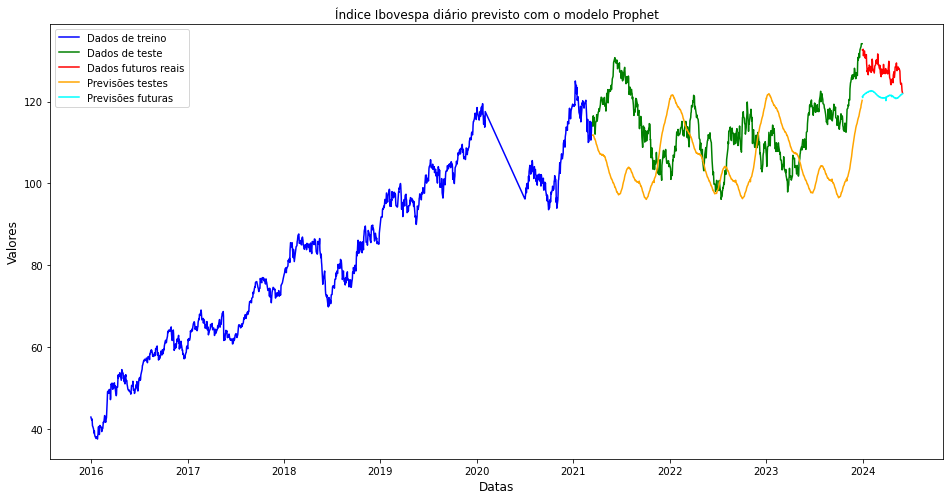

In [59]:
plt.figure(figsize=(16, 8))

plt.plot(treino_sem_pand['ds'], treino_sem_pand['y'],color='blue', label='Dados de treino')
plt.plot(teste['ds'], teste['y'],color='green', label='Dados de teste')
plt.plot(previsao['ds'], previsao['y'],color='red', label='Dados futuros reais')
plt.plot(teste['ds'],predicao['yhat'],color='orange', label='Previsões testes')
plt.plot(previsao['ds'],predicao2['yhat'],color='cyan', label='Previsões futuras')

plt.ylabel('Valores', fontsize=12)
plt.xlabel('Datas', fontsize=12)
plt.title('Índice Ibovespa diário previsto com o modelo Prophet')
# Adicionando uma legenda
plt.legend()

# Exibindo o gráfico
plt.show()

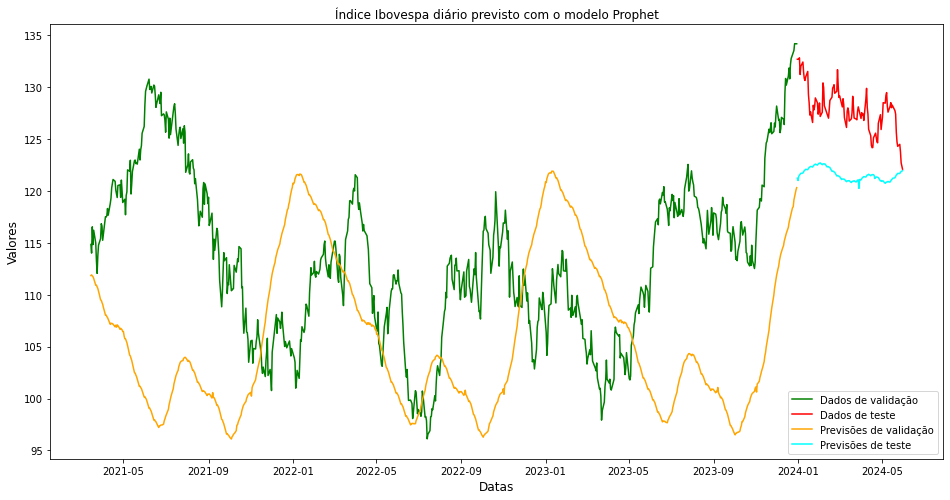

In [60]:
plt.figure(figsize=(16, 8))

#plt.plot(treino_sem_pand['ds'], treino_sem_pand['y'],color='blue', label='Dados de treino')
plt.plot(teste['ds'], teste['y'],color='green', label='Dados de validação')
plt.plot(previsao['ds'], previsao['y'],color='red', label='Dados de teste')
plt.plot(teste['ds'],predicao['yhat'],color='orange', label='Previsões de validação')
plt.plot(previsao['ds'],predicao2['yhat'],color='cyan', label='Previsões de teste')

plt.ylabel('Valores', fontsize=12)
plt.xlabel('Datas', fontsize=12)
plt.title('Índice Ibovespa diário previsto com o modelo Prophet')
# Adicionando uma legenda
plt.legend()

# Exibindo o gráfico
plt.show()

In [61]:
print('RMSE:',RMSE)
print('MAE:',MAE)
print('MAPE:',MAPE)

RMSE: 6.659967395606669
MAE: 6.319088654277171
MAPE: 0.049167724721012065


# Série com dados mensais


In [21]:
treino_mensal = treino.copy()
teste_mensal = teste.copy()
previsao_mensal = previsao.copy()

In [22]:
treino_mensal

,ds,y
data,,
2010-01-01,2010-01-01,70.04508
2010-01-02,2010-01-02,70.04508
2010-01-03,2010-01-03,70.04508
2010-01-04,2010-01-04,70.04508
2010-01-05,2010-01-05,70.23982
...,...,...
2021-03-10,2021-03-10,112.77649
2021-03-11,2021-03-11,114.98376
2021-03-12,2021-03-12,114.16040


In [24]:
treino_mensal = treino_mensal.resample('M', on='ds').mean()
teste_mensal = teste_mensal.resample('M', on='ds').mean()
previsao_mensal = previsao_mensal.resample('M', on='ds').mean()

In [25]:
treino_mensal['ds']=treino_mensal.index
teste_mensal['ds']=teste_mensal.index
previsao_mensal['ds']=previsao_mensal.index

## Separando conjunto de parâmetros para o grid search

In [26]:
params_grid = {'seasonality_mode':(['additive','multiplicative']),
               'changepoint_prior_scale':[0.01,0.04, 0.08],
              'holidays_prior_scale': [1,5,8],
               'changepoint_range':[0.4,0.6,0.8],
              'n_changepoints' : [2,5,10,15]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 216


## Treinamento do modelo e aplicação do grid search

In [27]:
%%time
model_parameters = pd.DataFrame(columns = ['RMSE','Parameters'])
best_rmse = np.inf
best_prediction=None
count = 0
for p in grid:
    
    test = pd.DataFrame()
    print(p)
    random.seed(0)
    train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         holidays_prior_scale = p['holidays_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         changepoint_range=p['changepoint_range'],
                         seasonality_mode = p['seasonality_mode'],
                         weekly_seasonality=True,
                         daily_seasonality = True,
                         yearly_seasonality = True,
                         holidays=holiday, 
                         interval_width=0.95)
    train_model.add_country_holidays(country_name='BR')
    train_model.fit(treino_mensal)
    train_forecast = train_model.make_future_dataframe(periods=len(teste_mensal), freq='M',include_history = False)
    train_forecast = train_model.predict(train_forecast)
    predicao=train_forecast[['ds','yhat']]
    Actual = teste_mensal
    RMSE = np.sqrt(mean_squared_error(Actual['y'], predicao['yhat']))
    MAE = mean_absolute_error(Actual['y'], predicao['yhat'])
    MAPE = mean_absolute_percentage_error(Actual['y'], predicao['yhat'])
    if RMSE < best_rmse:
        best_rmse = RMSE
        best_mae = MAE
        best_mape = MAPE
        best_prediction2 = train_forecast
    print('Root Mean Square Error(RMSE)------------------------------------',RMSE)
    model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
    count += 1
    print("total: " ,round(count/cnt,2)*100)

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


18:50:51 - cmdstanpy - INFO - Chain [1] start processing
18:50:51 - cmdstanpy - INFO - Chain [1] done processing
18:50:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:50:51 - cmdstanpy - INFO - Chain [1] start processing
18:50:51 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 18.5988216005267
total:  0.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


18:50:52 - cmdstanpy - INFO - Chain [1] start processing
18:50:52 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 17.31307636230058
total:  1.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 5, 'seasonality_mode': 'additive'}


18:50:52 - cmdstanpy - INFO - Chain [1] start processing
18:50:52 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 20.137205784748446
total:  1.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 5, 'seasonality_mode': 'multiplicative'}


18:50:53 - cmdstanpy - INFO - Chain [1] start processing
18:50:53 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 20.665756317336275
total:  2.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


18:50:53 - cmdstanpy - INFO - Chain [1] start processing
18:50:53 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 21.53053005870742
total:  2.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


18:50:54 - cmdstanpy - INFO - Chain [1] start processing
18:50:54 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.437513193340674
total:  3.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:50:54 - cmdstanpy - INFO - Chain [1] start processing
18:50:55 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.30113312320189
total:  3.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:50:56 - cmdstanpy - INFO - Chain [1] start processing
18:50:57 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.99319108041828
total:  4.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:50:58 - cmdstanpy - INFO - Chain [1] start processing
18:50:58 - cmdstanpy - INFO - Chain [1] done processing
18:50:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:50:58 - cmdstanpy - INFO - Chain [1] start processing
18:50:58 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.5988216005267
total:  4.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:50:59 - cmdstanpy - INFO - Chain [1] start processing
18:50:59 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.31307636230058
total:  5.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 5, 'n_changepoints': 5, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:51:00 - cmdstanpy - INFO - Chain [1] start processing
18:51:00 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.137205784748446
total:  5.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 5, 'n_changepoints': 5, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:51:01 - cmdstanpy - INFO - Chain [1] start processing
18:51:01 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.665756317336275
total:  6.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:51:02 - cmdstanpy - INFO - Chain [1] start processing
18:51:02 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.53053005870742
total:  6.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:51:03 - cmdstanpy - INFO - Chain [1] start processing
18:51:03 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.437513193340674
total:  6.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:51:04 - cmdstanpy - INFO - Chain [1] start processing
18:51:04 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.30113312320189
total:  7.000000000000001
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:51:05 - cmdstanpy - INFO - Chain [1] start processing
18:51:05 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.99319108041828
total:  7.000000000000001
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 8, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:51:06 - cmdstanpy - INFO - Chain [1] start processing
18:51:07 - cmdstanpy - INFO - Chain [1] done processing
18:51:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:51:07 - cmdstanpy - INFO - Chain [1] start processing
18:51:07 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.598821600526787
total:  8.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 8, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:51:08 - cmdstanpy - INFO - Chain [1] start processing
18:51:08 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.31307636230058
total:  8.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 8, 'n_changepoints': 5, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:51:09 - cmdstanpy - INFO - Chain [1] start processing
18:51:09 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:51:09 - cmdstanpy - INFO - Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 20.137205784748446
total:  9.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 8, 'n_changepoints': 5, 'seasonality_mode': 'multiplicative'}


18:51:09 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 20.665756317336275
total:  9.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 8, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


18:51:10 - cmdstanpy - INFO - Chain [1] start processing
18:51:10 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 21.53053005870742
total:  10.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 8, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


18:51:10 - cmdstanpy - INFO - Chain [1] start processing
18:51:10 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 21.437513193340674
total:  10.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 8, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


18:51:10 - cmdstanpy - INFO - Chain [1] start processing
18:51:10 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 18.30113312320189
total:  11.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 8, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


18:51:11 - cmdstanpy - INFO - Chain [1] start processing
18:51:11 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 21.99319108041828
total:  11.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


18:51:11 - cmdstanpy - INFO - Chain [1] start processing
18:51:11 - cmdstanpy - INFO - Chain [1] done processing
18:51:11 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:51:11 - cmdstanpy - INFO - Chain [1] start processing
18:51:11 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 18.512462502032257
total:  12.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


18:51:12 - cmdstanpy - INFO - Chain [1] start processing
18:51:12 - cmdstanpy - INFO - Chain [1] done processing
18:51:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:51:12 - cmdstanpy - INFO - Chain [1] start processing
18:51:12 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 18.987033180813334
total:  12.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 5, 'seasonality_mode': 'additive'}


18:51:12 - cmdstanpy - INFO - Chain [1] start processing
18:51:12 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 20.612859883194215
total:  12.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 5, 'seasonality_mode': 'multiplicative'}


18:51:13 - cmdstanpy - INFO - Chain [1] start processing
18:51:13 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 20.443638015240804
total:  13.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


18:51:13 - cmdstanpy - INFO - Chain [1] start processing
18:51:13 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 20.824384668870152
total:  13.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


18:51:13 - cmdstanpy - INFO - Chain [1] start processing
18:51:14 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 20.913030059806733
total:  14.000000000000002
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


18:51:14 - cmdstanpy - INFO - Chain [1] start processing
18:51:14 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 19.620694806560664
total:  14.000000000000002
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


18:51:14 - cmdstanpy - INFO - Chain [1] start processing
18:51:14 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 18.731821866245525
total:  15.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


18:51:15 - cmdstanpy - INFO - Chain [1] start processing
18:51:15 - cmdstanpy - INFO - Chain [1] done processing
18:51:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:51:15 - cmdstanpy - INFO - Chain [1] start processing
18:51:15 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.512462502005878
total:  15.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:51:16 - cmdstanpy - INFO - Chain [1] start processing
18:51:16 - cmdstanpy - INFO - Chain [1] done processing
18:51:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:51:16 - cmdstanpy - INFO - Chain [1] start processing
18:51:17 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.98703318081214
total:  16.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 5, 'n_changepoints': 5, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:51:18 - cmdstanpy - INFO - Chain [1] start processing
18:51:18 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.612859883194215
total:  16.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 5, 'n_changepoints': 5, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:51:18 - cmdstanpy - INFO - Chain [1] start processing
18:51:19 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.443638015240804
total:  17.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:51:19 - cmdstanpy - INFO - Chain [1] start processing
18:51:20 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.824384668870152
total:  17.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:51:20 - cmdstanpy - INFO - Chain [1] start processing
18:51:20 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.913030059806733
total:  18.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:51:21 - cmdstanpy - INFO - Chain [1] start processing
18:51:21 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.620694806560664
total:  18.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:51:22 - cmdstanpy - INFO - Chain [1] start processing
18:51:22 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.731821866245525
total:  19.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 8, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:51:23 - cmdstanpy - INFO - Chain [1] start processing
18:51:23 - cmdstanpy - INFO - Chain [1] done processing
18:51:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:51:23 - cmdstanpy - INFO - Chain [1] start processing
18:51:24 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.512462502014703
total:  19.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 8, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:51:24 - cmdstanpy - INFO - Chain [1] start processing
18:51:24 - cmdstanpy - INFO - Chain [1] done processing
18:51:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:51:24 - cmdstanpy - INFO - Chain [1] start processing
18:51:24 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 18.987033180811917
total:  19.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 8, 'n_changepoints': 5, 'seasonality_mode': 'additive'}


18:51:25 - cmdstanpy - INFO - Chain [1] start processing
18:51:25 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:51:25 - cmdstanpy - INFO - Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 20.612859883194215
total:  20.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 8, 'n_changepoints': 5, 'seasonality_mode': 'multiplicative'}


18:51:25 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 20.443638015240804
total:  20.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 8, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


18:51:25 - cmdstanpy - INFO - Chain [1] start processing
18:51:25 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 20.824384668870152
total:  21.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 8, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


18:51:26 - cmdstanpy - INFO - Chain [1] start processing
18:51:26 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 20.913030059806733
total:  21.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 8, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


18:51:26 - cmdstanpy - INFO - Chain [1] start processing
18:51:26 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 19.620694806560664
total:  22.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 8, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


18:51:27 - cmdstanpy - INFO - Chain [1] start processing
18:51:27 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:51:27 - cmdstanpy - INFO - Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 18.731821866245525
total:  22.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


18:51:27 - cmdstanpy - INFO - Chain [1] done processing
18:51:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:51:27 - cmdstanpy - INFO - Chain [1] start processing
18:51:27 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:51:28 - cmdstanpy - INFO - Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 18.596972414641755
total:  23.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


18:51:28 - cmdstanpy - INFO - Chain [1] done processing
18:51:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:51:28 - cmdstanpy - INFO - Chain [1] start processing
18:51:28 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 19.007662435028042
total:  23.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 5, 'seasonality_mode': 'additive'}


18:51:28 - cmdstanpy - INFO - Chain [1] start processing
18:51:28 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 18.67009939126947
total:  24.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 5, 'seasonality_mode': 'multiplicative'}


18:51:29 - cmdstanpy - INFO - Chain [1] start processing
18:51:29 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 21.29091779133732
total:  24.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


18:51:29 - cmdstanpy - INFO - Chain [1] start processing
18:51:29 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 18.98836855609637
total:  25.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


18:51:30 - cmdstanpy - INFO - Chain [1] start processing
18:51:30 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 21.20324942935588
total:  25.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


18:51:30 - cmdstanpy - INFO - Chain [1] start processing
18:51:30 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.96845313136236
total:  25.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:51:31 - cmdstanpy - INFO - Chain [1] start processing
18:51:31 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.566778055922363
total:  26.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:51:32 - cmdstanpy - INFO - Chain [1] start processing
18:51:32 - cmdstanpy - INFO - Chain [1] done processing
18:51:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:51:32 - cmdstanpy - INFO - Chain [1] start processing
18:51:33 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.596972414641755
total:  26.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:51:34 - cmdstanpy - INFO - Chain [1] start processing
18:51:34 - cmdstanpy - INFO - Chain [1] done processing
18:51:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:51:34 - cmdstanpy - INFO - Chain [1] start processing
18:51:34 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.007662435026518
total:  27.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'n_changepoints': 5, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:51:35 - cmdstanpy - INFO - Chain [1] start processing
18:51:35 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.67009939126947
total:  27.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'n_changepoints': 5, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:51:36 - cmdstanpy - INFO - Chain [1] start processing
18:51:36 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.29091779133732
total:  28.000000000000004
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:51:37 - cmdstanpy - INFO - Chain [1] start processing
18:51:37 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.98836855609637
total:  28.000000000000004
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:51:38 - cmdstanpy - INFO - Chain [1] start processing
18:51:38 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.20324942935588
total:  28.999999999999996
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:51:39 - cmdstanpy - INFO - Chain [1] start processing
18:51:39 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.96845313136236
total:  28.999999999999996
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:51:40 - cmdstanpy - INFO - Chain [1] start processing
18:51:40 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.566778055922363
total:  30.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 8, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:51:40 - cmdstanpy - INFO - Chain [1] start processing
18:51:40 - cmdstanpy - INFO - Chain [1] done processing
18:51:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:51:40 - cmdstanpy - INFO - Chain [1] start processing
18:51:41 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 18.596972414641755
total:  30.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 8, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


18:51:41 - cmdstanpy - INFO - Chain [1] start processing
18:51:41 - cmdstanpy - INFO - Chain [1] done processing
18:51:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:51:41 - cmdstanpy - INFO - Chain [1] start processing
18:51:41 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:51:41 - cmdstanpy - INFO - Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 19.00766243502723
total:  31.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 8, 'n_changepoints': 5, 'seasonality_mode': 'additive'}


18:51:42 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 18.67009939126947
total:  31.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 8, 'n_changepoints': 5, 'seasonality_mode': 'multiplicative'}


18:51:42 - cmdstanpy - INFO - Chain [1] start processing
18:51:42 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:51:42 - cmdstanpy - INFO - Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 21.29091779133732
total:  31.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 8, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


18:51:42 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 18.98836855609637
total:  32.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 8, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


18:51:43 - cmdstanpy - INFO - Chain [1] start processing
18:51:43 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:51:43 - cmdstanpy - INFO - Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 21.20324942935588
total:  32.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 8, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


18:51:43 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:51:43 - cmdstanpy - INFO - Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 18.96845313136236
total:  33.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 8, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


18:51:43 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:51:44 - cmdstanpy - INFO - Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 20.566778055922363
total:  33.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


18:51:44 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 12.797339360157867
total:  34.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


18:51:44 - cmdstanpy - INFO - Chain [1] start processing
18:51:44 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:51:44 - cmdstanpy - INFO - Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 15.765598274024853
total:  34.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 5, 'seasonality_mode': 'additive'}


18:51:45 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 13.305673784366316
total:  35.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 5, 'seasonality_mode': 'multiplicative'}


18:51:45 - cmdstanpy - INFO - Chain [1] start processing
18:51:45 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 15.00749941656927
total:  35.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


18:51:45 - cmdstanpy - INFO - Chain [1] start processing
18:51:45 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:51:46 - cmdstanpy - INFO - Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 11.604577968946428
total:  36.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


18:51:46 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 14.639000399603255
total:  36.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


18:51:46 - cmdstanpy - INFO - Chain [1] start processing
18:51:46 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 11.75228504028147
total:  37.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


18:51:46 - cmdstanpy - INFO - Chain [1] start processing
18:51:47 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 14.944619782352841
total:  37.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


18:51:47 - cmdstanpy - INFO - Chain [1] start processing
18:51:47 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 12.797339360157867
total:  38.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


18:51:47 - cmdstanpy - INFO - Chain [1] start processing
18:51:47 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.765598274024853
total:  38.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 5, 'n_changepoints': 5, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:51:48 - cmdstanpy - INFO - Chain [1] start processing
18:51:48 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.305673784366316
total:  38.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 5, 'n_changepoints': 5, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:51:49 - cmdstanpy - INFO - Chain [1] start processing
18:51:50 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.00749941656927
total:  39.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:51:50 - cmdstanpy - INFO - Chain [1] start processing
18:51:51 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.604577968946428
total:  39.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:51:51 - cmdstanpy - INFO - Chain [1] start processing
18:51:52 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.639000399603255
total:  40.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:51:52 - cmdstanpy - INFO - Chain [1] start processing
18:51:53 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.75228504028147
total:  40.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:51:54 - cmdstanpy - INFO - Chain [1] start processing
18:51:54 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.944619782352841
total:  41.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 8, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:51:54 - cmdstanpy - INFO - Chain [1] start processing
18:51:55 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.797339360157867
total:  41.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 8, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:51:55 - cmdstanpy - INFO - Chain [1] start processing
18:51:55 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.765598274024853
total:  42.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 8, 'n_changepoints': 5, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:51:56 - cmdstanpy - INFO - Chain [1] start processing
18:51:56 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.305673784366316
total:  42.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 8, 'n_changepoints': 5, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:51:57 - cmdstanpy - INFO - Chain [1] start processing
18:51:57 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 15.00749941656927
total:  43.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 8, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


18:51:58 - cmdstanpy - INFO - Chain [1] start processing
18:51:58 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 11.604577968946428
total:  43.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 8, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


18:51:58 - cmdstanpy - INFO - Chain [1] start processing
18:51:58 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 14.639000399603255
total:  44.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 8, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


18:51:58 - cmdstanpy - INFO - Chain [1] start processing
18:51:58 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:51:59 - cmdstanpy - INFO - Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 11.75228504028147
total:  44.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 8, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


18:51:59 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:51:59 - cmdstanpy - INFO - Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 14.944619782352841
total:  44.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


18:51:59 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 23.67238790059855
total:  45.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


18:52:00 - cmdstanpy - INFO - Chain [1] start processing
18:52:00 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 26.062508531998553
total:  45.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 5, 'seasonality_mode': 'additive'}


18:52:00 - cmdstanpy - INFO - Chain [1] start processing
18:52:00 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 21.94118759725688
total:  46.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 5, 'seasonality_mode': 'multiplicative'}


18:52:00 - cmdstanpy - INFO - Chain [1] start processing
18:52:00 - cmdstanpy - INFO - Chain [1] done processing
18:52:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:52:00 - cmdstanpy - INFO - Chain [1] start processing
18:52:01 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 23.544232303149446
total:  46.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


18:52:02 - cmdstanpy - INFO - Chain [1] start processing
18:52:02 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 21.868048779284248
total:  47.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


18:52:02 - cmdstanpy - INFO - Chain [1] start processing
18:52:02 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 23.3136730425412
total:  47.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


18:52:03 - cmdstanpy - INFO - Chain [1] start processing
18:52:03 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:52:03 - cmdstanpy - INFO - Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 20.881661517905126
total:  48.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


18:52:03 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 23.17073048390756
total:  48.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


18:52:03 - cmdstanpy - INFO - Chain [1] start processing
18:52:03 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 23.67238790059855
total:  49.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


18:52:04 - cmdstanpy - INFO - Chain [1] start processing
18:52:04 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 26.062508531998553
total:  49.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 5, 'n_changepoints': 5, 'seasonality_mode': 'additive'}


18:52:04 - cmdstanpy - INFO - Chain [1] start processing
18:52:04 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:52:05 - cmdstanpy - INFO - Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 21.94118759725688
total:  50.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 5, 'n_changepoints': 5, 'seasonality_mode': 'multiplicative'}


18:52:05 - cmdstanpy - INFO - Chain [1] done processing
18:52:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:52:05 - cmdstanpy - INFO - Chain [1] start processing
18:52:06 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:52:06 - cmdstanpy - INFO - Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 23.5444545505462
total:  50.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


18:52:06 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:52:06 - cmdstanpy - INFO - Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 21.868048779284248
total:  50.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


18:52:06 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 23.3136730425412
total:  51.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


18:52:07 - cmdstanpy - INFO - Chain [1] start processing
18:52:07 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 20.881661517905126
total:  51.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


18:52:07 - cmdstanpy - INFO - Chain [1] start processing
18:52:07 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 23.17073048390756
total:  52.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 8, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


18:52:08 - cmdstanpy - INFO - Chain [1] start processing
18:52:08 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.67238790059855
total:  52.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 8, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:52:09 - cmdstanpy - INFO - Chain [1] start processing
18:52:09 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 26.062508531998553
total:  53.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 8, 'n_changepoints': 5, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:52:10 - cmdstanpy - INFO - Chain [1] start processing
18:52:10 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.94118759725688
total:  53.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 8, 'n_changepoints': 5, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:52:11 - cmdstanpy - INFO - Chain [1] start processing
18:52:11 - cmdstanpy - INFO - Chain [1] done processing
18:52:11 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:52:11 - cmdstanpy - INFO - Chain [1] start processing
18:52:14 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.54446007717224
total:  54.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 8, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:52:15 - cmdstanpy - INFO - Chain [1] start processing
18:52:15 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.868048779284248
total:  54.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 8, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:52:16 - cmdstanpy - INFO - Chain [1] start processing
18:52:16 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.3136730425412
total:  55.00000000000001
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 8, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:52:17 - cmdstanpy - INFO - Chain [1] start processing
18:52:17 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.881661517905126
total:  55.00000000000001
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 8, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:52:18 - cmdstanpy - INFO - Chain [1] start processing
18:52:18 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.17073048390756
total:  56.00000000000001
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:52:19 - cmdstanpy - INFO - Chain [1] start processing
18:52:19 - cmdstanpy - INFO - Chain [1] done processing
18:52:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:52:20 - cmdstanpy - INFO - Chain [1] start processing
18:52:20 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.272968119068903
total:  56.00000000000001
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:52:21 - cmdstanpy - INFO - Chain [1] start processing
18:52:21 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.345175138999707
total:  56.00000000000001
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 5, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:52:22 - cmdstanpy - INFO - Chain [1] start processing
18:52:22 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.025997894674447
total:  56.99999999999999
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 5, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:52:23 - cmdstanpy - INFO - Chain [1] start processing
18:52:23 - cmdstanpy - INFO - Chain [1] done processing
18:52:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:52:23 - cmdstanpy - INFO - Chain [1] start processing
18:52:25 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.490714178662085
total:  56.99999999999999
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:52:26 - cmdstanpy - INFO - Chain [1] start processing
18:52:26 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.117861655447754
total:  57.99999999999999
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:52:27 - cmdstanpy - INFO - Chain [1] start processing
18:52:27 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 15.907293998495444
total:  57.99999999999999
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


18:52:27 - cmdstanpy - INFO - Chain [1] start processing
18:52:27 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 21.21262831174559
total:  59.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


18:52:28 - cmdstanpy - INFO - Chain [1] start processing
18:52:28 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 15.99300197856161
total:  59.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


18:52:28 - cmdstanpy - INFO - Chain [1] start processing
18:52:28 - cmdstanpy - INFO - Chain [1] done processing
18:52:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:52:28 - cmdstanpy - INFO - Chain [1] start processing
18:52:29 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 13.272968119089171
total:  60.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


18:52:29 - cmdstanpy - INFO - Chain [1] start processing
18:52:29 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 21.345175138999707
total:  60.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'n_changepoints': 5, 'seasonality_mode': 'additive'}


18:52:29 - cmdstanpy - INFO - Chain [1] start processing
18:52:29 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 20.025997894674447
total:  61.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'n_changepoints': 5, 'seasonality_mode': 'multiplicative'}


18:52:30 - cmdstanpy - INFO - Chain [1] start processing
18:52:30 - cmdstanpy - INFO - Chain [1] done processing
18:52:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:52:30 - cmdstanpy - INFO - Chain [1] start processing
18:52:31 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 13.490894320053968
total:  61.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


18:52:31 - cmdstanpy - INFO - Chain [1] start processing
18:52:31 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 21.117861655447754
total:  62.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


18:52:31 - cmdstanpy - INFO - Chain [1] start processing
18:52:31 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 15.907293998495444
total:  62.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


18:52:32 - cmdstanpy - INFO - Chain [1] start processing
18:52:32 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.21262831174559
total:  62.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:52:32 - cmdstanpy - INFO - Chain [1] start processing
18:52:32 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 15.99300197856161
total:  63.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 8, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


18:52:33 - cmdstanpy - INFO - Chain [1] start processing
18:52:33 - cmdstanpy - INFO - Chain [1] done processing
18:52:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:52:33 - cmdstanpy - INFO - Chain [1] start processing
18:52:33 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 13.272968119151994
total:  63.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 8, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


18:52:33 - cmdstanpy - INFO - Chain [1] start processing
18:52:33 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 21.345175138999707
total:  64.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 8, 'n_changepoints': 5, 'seasonality_mode': 'additive'}


18:52:34 - cmdstanpy - INFO - Chain [1] start processing
18:52:34 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 20.025997894674447
total:  64.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 8, 'n_changepoints': 5, 'seasonality_mode': 'multiplicative'}


18:52:34 - cmdstanpy - INFO - Chain [1] start processing
18:52:34 - cmdstanpy - INFO - Chain [1] done processing
18:52:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:52:34 - cmdstanpy - INFO - Chain [1] start processing
18:52:35 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.490724993349112
total:  65.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 8, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:52:36 - cmdstanpy - INFO - Chain [1] start processing
18:52:36 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.117861655447754
total:  65.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 8, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:52:37 - cmdstanpy - INFO - Chain [1] start processing
18:52:37 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.907293998495444
total:  66.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 8, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:52:38 - cmdstanpy - INFO - Chain [1] start processing
18:52:39 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.21262831174559
total:  66.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 8, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:52:39 - cmdstanpy - INFO - Chain [1] start processing
18:52:40 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.99300197856161
total:  67.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:52:40 - cmdstanpy - INFO - Chain [1] start processing
18:52:40 - cmdstanpy - INFO - Chain [1] done processing
18:52:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:52:40 - cmdstanpy - INFO - Chain [1] start processing
18:52:41 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.703832481901767
total:  67.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:52:42 - cmdstanpy - INFO - Chain [1] start processing
18:52:42 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.693627039014322
total:  68.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 5, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:52:43 - cmdstanpy - INFO - Chain [1] start processing
18:52:43 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.597691722424075
total:  68.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 5, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:52:44 - cmdstanpy - INFO - Chain [1] start processing
18:52:44 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.314865187712876
total:  69.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:52:45 - cmdstanpy - INFO - Chain [1] start processing
18:52:45 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.013884411730842
total:  69.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:52:46 - cmdstanpy - INFO - Chain [1] start processing
18:52:46 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.419942393989997
total:  69.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:52:46 - cmdstanpy - INFO - Chain [1] start processing
18:52:46 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 13.273553650546058
total:  70.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


18:52:47 - cmdstanpy - INFO - Chain [1] start processing
18:52:47 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:52:47 - cmdstanpy - INFO - Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 15.38676053055201
total:  70.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


18:52:47 - cmdstanpy - INFO - Chain [1] done processing
18:52:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:52:47 - cmdstanpy - INFO - Chain [1] start processing
18:52:47 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:52:48 - cmdstanpy - INFO - Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 13.703832481972356
total:  71.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


18:52:48 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 15.693627039014322
total:  71.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 5, 'n_changepoints': 5, 'seasonality_mode': 'additive'}


18:52:48 - cmdstanpy - INFO - Chain [1] start processing
18:52:48 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 13.597691722424075
total:  72.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 5, 'n_changepoints': 5, 'seasonality_mode': 'multiplicative'}


18:52:48 - cmdstanpy - INFO - Chain [1] start processing
18:52:48 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 16.314865187712876
total:  72.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


18:52:49 - cmdstanpy - INFO - Chain [1] start processing
18:52:49 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:52:49 - cmdstanpy - INFO - Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 13.013884411730842
total:  73.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


18:52:49 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:52:49 - cmdstanpy - INFO - Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 15.419942393989997
total:  73.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


18:52:49 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:52:50 - cmdstanpy - INFO - Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 13.273553650546058
total:  74.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


18:52:50 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:52:50 - cmdstanpy - INFO - Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 15.38676053055201
total:  74.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 8, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


18:52:50 - cmdstanpy - INFO - Chain [1] done processing
18:52:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:52:50 - cmdstanpy - INFO - Chain [1] start processing
18:52:50 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 13.703832481822795
total:  75.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 8, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


18:52:51 - cmdstanpy - INFO - Chain [1] start processing
18:52:51 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 15.693627039014322
total:  75.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 8, 'n_changepoints': 5, 'seasonality_mode': 'additive'}


18:52:51 - cmdstanpy - INFO - Chain [1] start processing
18:52:51 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 13.597691722424075
total:  75.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 8, 'n_changepoints': 5, 'seasonality_mode': 'multiplicative'}


18:52:52 - cmdstanpy - INFO - Chain [1] start processing
18:52:52 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:52:52 - cmdstanpy - INFO - Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 16.314865187712876
total:  76.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 8, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


18:52:52 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 13.013884411730842
total:  76.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 8, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


18:52:52 - cmdstanpy - INFO - Chain [1] start processing
18:52:52 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:52:53 - cmdstanpy - INFO - Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 15.419942393989997
total:  77.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 8, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


18:52:53 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:52:53 - cmdstanpy - INFO - Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 13.273553650546058
total:  77.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 8, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


18:52:53 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 15.38676053055201
total:  78.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


18:52:54 - cmdstanpy - INFO - Chain [1] start processing
18:52:54 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 24.74807509854113
total:  78.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


18:52:54 - cmdstanpy - INFO - Chain [1] start processing
18:52:54 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:52:54 - cmdstanpy - INFO - Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 26.09383401281769
total:  79.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 5, 'seasonality_mode': 'additive'}


18:52:54 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:52:55 - cmdstanpy - INFO - Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 22.672083354016433
total:  79.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 5, 'seasonality_mode': 'multiplicative'}


18:52:55 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:52:55 - cmdstanpy - INFO - Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 23.33793514136996
total:  80.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


18:52:55 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 22.437525972144744
total:  80.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


18:52:55 - cmdstanpy - INFO - Chain [1] start processing
18:52:56 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 21.771927143920326
total:  81.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


18:52:56 - cmdstanpy - INFO - Chain [1] start processing
18:52:56 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 21.975046609946045
total:  81.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


18:52:56 - cmdstanpy - INFO - Chain [1] start processing
18:52:56 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:52:57 - cmdstanpy - INFO - Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 22.919257205941637
total:  81.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


18:52:57 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 24.74807509854113
total:  82.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


18:52:57 - cmdstanpy - INFO - Chain [1] start processing
18:52:57 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:52:57 - cmdstanpy - INFO - Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 26.09383401281769
total:  82.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 5, 'n_changepoints': 5, 'seasonality_mode': 'additive'}


18:52:57 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 22.672083354016433
total:  83.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 5, 'n_changepoints': 5, 'seasonality_mode': 'multiplicative'}


18:52:58 - cmdstanpy - INFO - Chain [1] start processing
18:52:58 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 23.33793514136996
total:  83.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


18:52:58 - cmdstanpy - INFO - Chain [1] start processing
18:52:58 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.437525972144744
total:  84.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:52:59 - cmdstanpy - INFO - Chain [1] start processing
18:52:59 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.771927143920326
total:  84.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:53:01 - cmdstanpy - INFO - Chain [1] start processing
18:53:01 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.975046609946045
total:  85.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:53:02 - cmdstanpy - INFO - Chain [1] start processing
18:53:02 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.919257205941637
total:  85.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 8, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:53:03 - cmdstanpy - INFO - Chain [1] start processing
18:53:03 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 24.74807509854113
total:  86.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 8, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:53:04 - cmdstanpy - INFO - Chain [1] start processing
18:53:04 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 26.09383401281769
total:  86.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 8, 'n_changepoints': 5, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:53:05 - cmdstanpy - INFO - Chain [1] start processing
18:53:05 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.672083354016433
total:  87.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 8, 'n_changepoints': 5, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:53:06 - cmdstanpy - INFO - Chain [1] start processing
18:53:06 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.33793514136996
total:  87.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 8, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:53:07 - cmdstanpy - INFO - Chain [1] start processing
18:53:07 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.437525972144744
total:  88.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 8, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:53:08 - cmdstanpy - INFO - Chain [1] start processing
18:53:08 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.771927143920326
total:  88.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 8, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:53:09 - cmdstanpy - INFO - Chain [1] start processing
18:53:09 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.975046609946045
total:  88.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 8, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:53:10 - cmdstanpy - INFO - Chain [1] start processing
18:53:10 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.919257205941637
total:  89.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:53:11 - cmdstanpy - INFO - Chain [1] start processing
18:53:11 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.78668721911112
total:  89.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:53:12 - cmdstanpy - INFO - Chain [1] start processing
18:53:12 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.56818759725305
total:  90.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 5, 'seasonality_mode': 'additive'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:53:13 - cmdstanpy - INFO - Chain [1] start processing
18:53:13 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.242407498217037
total:  90.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 5, 'seasonality_mode': 'multiplicative'}


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:53:14 - cmdstanpy - INFO - Chain [1] start processing
18:53:14 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:53:15 - cmdstanpy - INFO - Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 13.406790897475002
total:  91.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


18:53:15 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 21.771381416620596
total:  91.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


18:53:15 - cmdstanpy - INFO - Chain [1] start processing
18:53:15 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:53:15 - cmdstanpy - INFO - Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 14.290900999525787
total:  92.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


18:53:16 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:53:16 - cmdstanpy - INFO - Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 21.431170963025814
total:  92.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


18:53:16 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 15.383780836873656
total:  93.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


18:53:16 - cmdstanpy - INFO - Chain [1] start processing
18:53:16 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 15.78668721911112
total:  93.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


18:53:17 - cmdstanpy - INFO - Chain [1] start processing
18:53:17 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:53:17 - cmdstanpy - INFO - Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 21.56818759725305
total:  94.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'n_changepoints': 5, 'seasonality_mode': 'additive'}


18:53:17 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:53:17 - cmdstanpy - INFO - Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 21.242407498217037
total:  94.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'n_changepoints': 5, 'seasonality_mode': 'multiplicative'}


18:53:17 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 13.406790897475002
total:  94.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


18:53:18 - cmdstanpy - INFO - Chain [1] start processing
18:53:18 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:53:18 - cmdstanpy - INFO - Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 21.771381416620596
total:  95.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


18:53:18 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:53:19 - cmdstanpy - INFO - Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 14.290900999525787
total:  95.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


18:53:19 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:53:19 - cmdstanpy - INFO - Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 21.431170963025814
total:  96.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


18:53:19 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 15.383780836873656
total:  96.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 8, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


18:53:19 - cmdstanpy - INFO - Chain [1] start processing
18:53:19 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 15.78668721911112
total:  97.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 8, 'n_changepoints': 2, 'seasonality_mode': 'multiplicative'}


18:53:20 - cmdstanpy - INFO - Chain [1] start processing
18:53:20 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:53:20 - cmdstanpy - INFO - Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 21.56818759725305
total:  97.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 8, 'n_changepoints': 5, 'seasonality_mode': 'additive'}


18:53:20 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:53:20 - cmdstanpy - INFO - Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 21.242407498217037
total:  98.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 8, 'n_changepoints': 5, 'seasonality_mode': 'multiplicative'}


18:53:20 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 13.406790897475002
total:  98.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 8, 'n_changepoints': 10, 'seasonality_mode': 'additive'}


18:53:21 - cmdstanpy - INFO - Chain [1] start processing
18:53:21 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Root Mean Square Error(RMSE)------------------------------------ 21.771381416620596
total:  99.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 8, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'}


18:53:21 - cmdstanpy - INFO - Chain [1] start processing
18:53:21 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:53:22 - cmdstanpy - INFO - Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 14.290900999525787
total:  99.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 8, 'n_changepoints': 15, 'seasonality_mode': 'additive'}


18:53:22 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
18:53:22 - cmdstanpy - INFO - Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 21.431170963025814
total:  100.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 8, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative'}


18:53:22 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.383780836873656
total:  100.0
CPU times: total: 43.5 s
Wall time: 2min 31s


<timed exec>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [41]:
parameters = model_parameters.sort_values(by=['RMSE'])
print('RMSE:',parameters.loc[0, 'RMSE'])
print('MAE:',parameters.loc[0, 'MAE'])
print('MAPE:',parameters.loc[0, 'MAPE'])
print(parameters.loc[0, 'Parameters'])

RMSE: 18.5988216005267
MAE: 16.234967112851788
MAPE: 0.13928389376325595
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 2, 'seasonality_mode': 'additive'}


## Realizando treinando modelo com dados de treino e validção e previsão para os dados de teste

In [42]:
treino_concat = pd.concat([treino_mensal,teste_mensal])
teste_concat_mensal = pd.concat([previsao_mensal])

In [43]:
train_model =Prophet(changepoint_prior_scale = parameters.loc[0, 'Parameters']['changepoint_prior_scale'],
                     holidays_prior_scale = parameters.loc[0, 'Parameters']['holidays_prior_scale'],
                     n_changepoints = parameters.loc[0, 'Parameters']['n_changepoints'],
                     changepoint_range=parameters.loc[0, 'Parameters']['changepoint_range'],
                     seasonality_mode = parameters.loc[0, 'Parameters']['seasonality_mode'],
                     weekly_seasonality=True,
                     daily_seasonality = True,
                     yearly_seasonality = True,
                     holidays=holiday, 
                     interval_width=0.95)
train_model.add_country_holidays(country_name='BR')
train_model.fit(treino_concat)
train_forecast = train_model.make_future_dataframe(periods=len(teste_concat_mensal), freq='M',include_history = False)
train_forecast = train_model.predict(train_forecast)
predicao=train_forecast[['ds','yhat']]
Actual = teste_concat_mensal
RMSE = np.sqrt(mean_squared_error(Actual['y'], predicao['yhat']))
MAE = mean_absolute_error(Actual['y'], predicao['yhat'])
MAPE = mean_absolute_percentage_error(Actual['y'], predicao['yhat'])

18:58:25 - cmdstanpy - INFO - Chain [1] start processing
18:58:25 - cmdstanpy - INFO - Chain [1] done processing
18:58:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:58:25 - cmdstanpy - INFO - Chain [1] start processing
18:58:25 - cmdstanpy - INFO - Chain [1] done processing


## Plotando dados

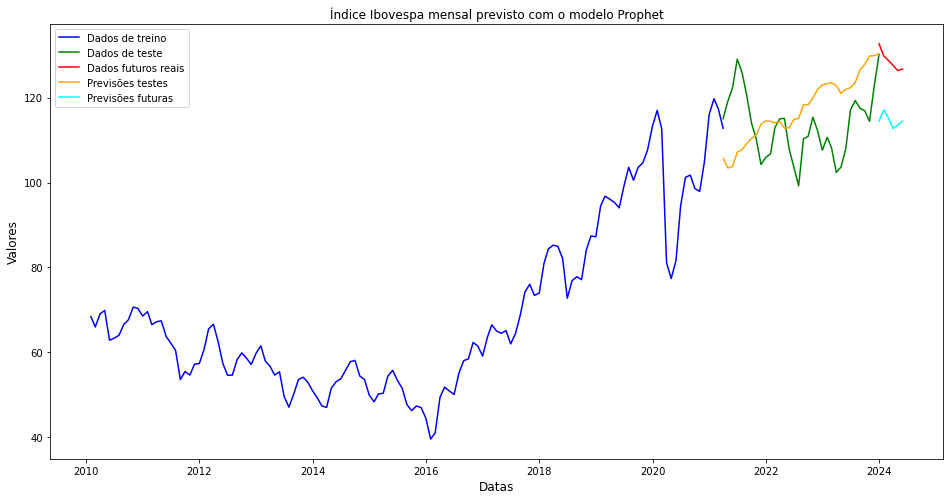

In [44]:
plt.figure(figsize=(16, 8))

plt.plot(treino_mensal['ds'], treino_mensal['y'],color='blue', label='Dados de treino')
plt.plot(teste_mensal['ds'], teste_mensal['y'],color='green', label='Dados de teste')
plt.plot(previsao_mensal['ds'], previsao_mensal['y'],color='red', label='Dados futuros reais')
plt.plot(teste_mensal['ds'],best_prediction2['yhat'],color='orange', label='Previsões testes')
plt.plot(previsao_mensal['ds'],predicao['yhat'],color='cyan', label='Previsões futuras')

plt.ylabel('Valores', fontsize=12)
plt.xlabel('Datas', fontsize=12)
plt.title('Índice Ibovespa mensal previsto com o modelo Prophet')
# Adicionando uma legenda
plt.legend()

# Exibindo o gráfico
plt.show()

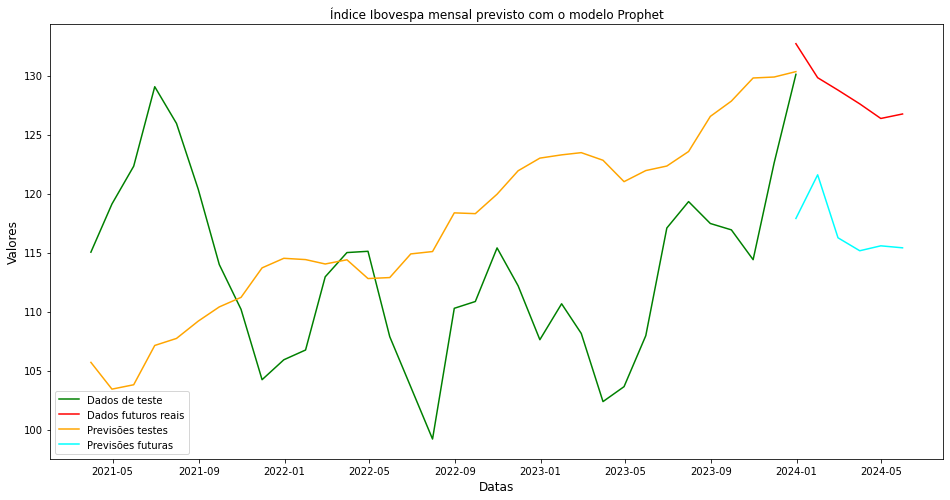

In [40]:
plt.figure(figsize=(16, 8))

#plt.plot(treino_mensal['ds'], treino_mensal['y'],color='blue', label='Dados de treino')
plt.plot(teste_mensal['ds'], teste_mensal['y'],color='green', label='Dados de teste')
plt.plot(previsao_mensal['ds'], previsao_mensal['y'],color='red', label='Dados futuros reais')
plt.plot(teste_mensal['ds'],best_prediction2['yhat'],color='orange', label='Previsões testes')
plt.plot(previsao_mensal['ds'],predicao['yhat'],color='cyan', label='Previsões futuras')

plt.ylabel('Valores', fontsize=12)
plt.xlabel('Datas', fontsize=12)
plt.title('Índice Ibovespa mensal previsto com o modelo Prophet')
# Adicionando uma legenda
plt.legend()

# Exibindo o gráfico
plt.show()

In [298]:
print('RMSE:',RMSE)
print('MAE:',MAE)
print('MAPE:',MAPE)

RMSE: 11.854215360971658
MAE: 11.685167049151998
MAPE: 0.09074126586103765
